### Analysis of Hubway Trip Time to Bike Rentral Request in Boston

This project uses data from the City of Bostom to compare Hubway bike rental metrics (number of bike rentals per hour, rental duration, etc.) against weather data for each of the Hubway station. We set out to achieve the following:

1) Determine if correlations between weather variables (temperarure, humidity, etc.) and Hubway bike rental metrics (number of Hubway bike rental requests, average trip time, number of Hibway bike rental request per hour) exist. Does the Hubway have more registered users than casual users? What variables most influence the number of Hubway bike rental per hour?

2) Determine if there is a statistically significant difference between northern and southern community areas in bike rental duration or the number of number of bike rental per hour. Perform k-means clustering to discover if census data can accurately predict a northern or southern community area.

3) Create regression model using machine learning to predict trip time and number of bike rental per hour given weather data for a particular area. This model could be used to predict the bike demand in the city for any hubway station and provide an estimate of bike inventory to be maintained for any season.

In [2]:
%pylab inline

import re
import math
import time
import random
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from time import mktime
import matplotlib.pyplot as plt
from datetime import date, datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor
from pandas.tseries.holiday import USFederalHolidayCalendar

sns.set_style(style='white')
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)

# 1 = spring, 2 = summer, 3 = fall, 4 = winter
seasons = [(4, (date(Y,  1,  1),  date(Y,  3, 20))),
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),
           (4, (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

print(get_season(date.today()))

4


In [4]:
weather = ['Clear', 'Rain', 'Rain , Thunderstorm', 'Fog , Rain',
       'Thunderstorm', 'Fog', 'Fog , Rain , Thunderstorm', 'Rain , Snow',
       'Rain , Hail , Thunderstorm', 'Snow']

#1. Clear, Clouds
#2. Mist, Drizzle, Fog
#3. Rain, Haze
#4. Snow, Thunderstorm, Squall
        
def getWeather(event):
    if (event == "Clear" or event == "Clouds"):
        return 1
    elif (event == "Mist" or event == "Drizzle" or event == 'Fog'):
        return 2
    elif (event == "Rain" or event == 'Haze'):
        return 3
    elif (event == "Snow" or event == 'Thunderstorm' or event == 'Squall'):
        return 4
    else:
        return 1
    
getWeather('Fog ')

1

In [5]:
def getWindchill(data):    
    vTemperature = data['TEMP']
    vWindSpeed = data['SPEED']
    vRelativeHumidity = data['HUMIDITY']
    
    # Try Wind Chill first
    if vTemperature <= 50 and vWindSpeed >= 3:
        vFeelsLike = 35.74 + (0.6215*vTemperature) - 35.75*(vWindSpeed**0.16) + ((0.4275*vTemperature)*(vWindSpeed**0.16))
    else:
        vFeelsLike = vTemperature

    # Replace it with the Heat Index, if necessary
    if vFeelsLike == vTemperature and vTemperature >= 80:
        vFeelsLike = 0.5 * (vTemperature + 61.0 + ((vTemperature-68.0)*1.2) + (vRelativeHumidity*0.094))

        if vFeelsLike >= 80:
            vFeelsLike = -42.379 + 2.04901523*vTemperature + 10.14333127*vRelativeHumidity - .22475541*vTemperature*vRelativeHumidity - .00683783*vTemperature*vTemperature - .05481717*vRelativeHumidity*vRelativeHumidity + .00122874*vTemperature*vTemperature*vRelativeHumidity + .00085282*vTemperature*vRelativeHumidity*vRelativeHumidity - .00000199*vTemperature*vTemperature*vRelativeHumidity*vRelativeHumidity
            if vRelativeHumidity < 13 and vTemperature >= 80 and vTemperature <= 112:
                vFeelsLike = vFeelsLike - ((13-vRelativeHumidity)/4)*math.sqrt((17-math.fabs(vTemperature-95.))/17)
            if vRelativeHumidity > 85 and vTemperature >= 80 and vTemperature <= 87:
                vFeelsLike = vFeelsLike + ((vRelativeHumidity-85)/10) * ((87-vTemperature)/5)
    return vFeelsLike

In [6]:
def getLattitude(station):
    dfStation = pd.read_csv('data/hubway_stations.csv') #,index_col='id')
    dfStation.columns = ['SST','TRN','STN','MNC','LAT','LNG','STA']
    return dfStation[dfStation['SST'] == station][['LAT']]

getLattitude(5)

,LAT
2,42.341814


In [7]:
def getLongitude(station):
    dfStation = pd.read_csv('data/hubway_stations.csv') #,index_col='id')
    dfStation.columns = ['SST','TRN','STN','MNC','LAT','LNG','STA']
    return dfStation[dfStation['SST'] == station][['LNG']]

getLongitude(5)

,LNG
2,-71.090179


In [8]:
def getAge(birth_year):
    now  = datetime.now()
    if birth_year != 0:
        return now.year - birth_year
    else:
        return 0

getAge(1980)

38

In [9]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [10]:
def getFahrenheit(K):
    F = (1.8*(K - 273.15)) + 32
    return round(F,0)

getFahrenheit(300)

80.0

### Hypothesis Generation

Here are some of the hypothesis which I thought could influence the demand of bikes:

* Hourly trend: There must be high demand during office timings. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.
* Daily Trend: Registered users demand more bike on weekdays as compared to weekend or holiday.
* Rain: The demand of bikes will be lower on a rainy day as compared to a sunny day. Similarly, higher humidity will cause to lower the demand and vice versa.
* Temperature: In India, temperature has negative correlation with bike demand. But, after looking at Washington’s temperature graph, I presume it may have positive correlation.
* Pollution: If the pollution level in a city starts soaring, people may start using Bike (it may be influenced by government / company policies or increased awareness).
* Traffic: It can be positively correlated with Bike demand. Higher traffic may force people to use bike as compared to other road transport medium like car, taxi etc

### Importing Data set and Basic Data Exploration

#### Importing Hubway trip data from csv

Link to dataset: http://hubwaydatachallenge.org/trip-history-data/

In [11]:
df1 = pd.read_csv('data/hubway_trips.csv',parse_dates=True, index_col='seq_id', na_values={''})

df1.columns = ['HID','STATUS','DURATION','START_DATE','START_STATION','END_DATE',
                   'END_STATION','BIKE_NO','SUB_TYPE','ZIPCODE','BIRTH_DATE','GENDER']

#### Cleaning the dataset

In [12]:
dfTrips = df1.copy()

#Convert completion date from string to datetime object
cleanedStartDate = []
for date in dfTrips['START_DATE']:
    if date != None:
        cleanedStartDate.append(datetime.strptime(date, '%m/%d/%Y %H:%M:%S'))
    else:
        cleanedStartDate.append(None)

del dfTrips['START_DATE'], dfTrips['END_DATE']

dfTrips.insert(1, 'START_DATE', cleanedStartDate)
dfTrips.insert(3, 'YEAR', dfTrips['START_DATE'].dt.year)
dfTrips['BIKE_NO']  = dfTrips['BIKE_NO'].fillna('').astype(str)

dfTrips.head(5)

,HID,START_DATE,STATUS,YEAR,DURATION,START_STATION,END_STATION,BIKE_NO,SUB_TYPE,ZIPCODE,BIRTH_DATE,GENDER
seq_id,,,,,,,,,,,,
1,8,2011-07-28 10:12:00,Closed,2011,9,23.0,23.0,B00468,Registered,'97217,1976.0,Male
2,9,2011-07-28 10:21:00,Closed,2011,220,23.0,23.0,B00554,Registered,'02215,1966.0,Male
3,10,2011-07-28 10:33:00,Closed,2011,56,23.0,23.0,B00456,Registered,'02108,1943.0,Male
4,11,2011-07-28 10:35:00,Closed,2011,64,23.0,23.0,B00554,Registered,'02116,1981.0,Female
5,12,2011-07-28 10:37:00,Closed,2011,12,23.0,23.0,B00554,Registered,'97214,1983.0,Female


##### Timeseries plot of Hubway Trip Data

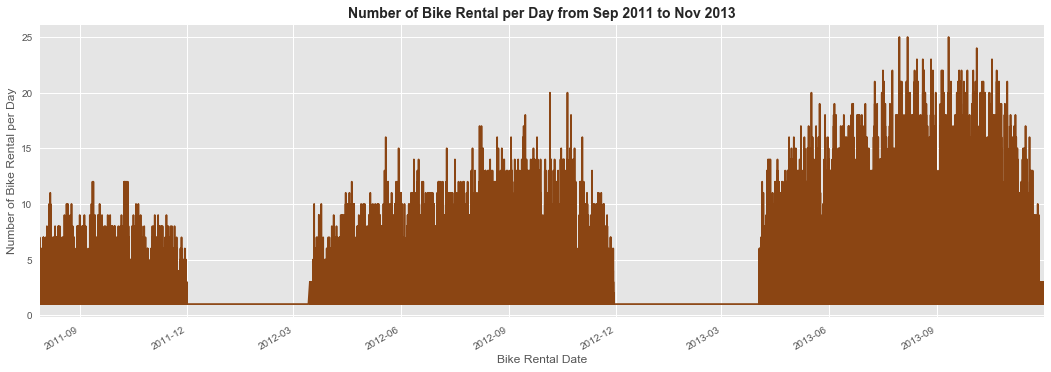

In [13]:
rentalByDate = dfTrips.groupby('START_DATE')['START_DATE'].count()
fig = plt.figure(figsize=(18, 6))
rentalByDate.plot(color = 'saddlebrown')
plt.ylabel('Number of Bike Rental per Day', fontsize = 12)
plt.xlabel('Bike Rental Date', fontsize = 12)
plt.title('Number of Bike Rental per Day from Sep 2011 to Nov 2013', fontsize = 14, fontweight = 'bold');

plt.show()

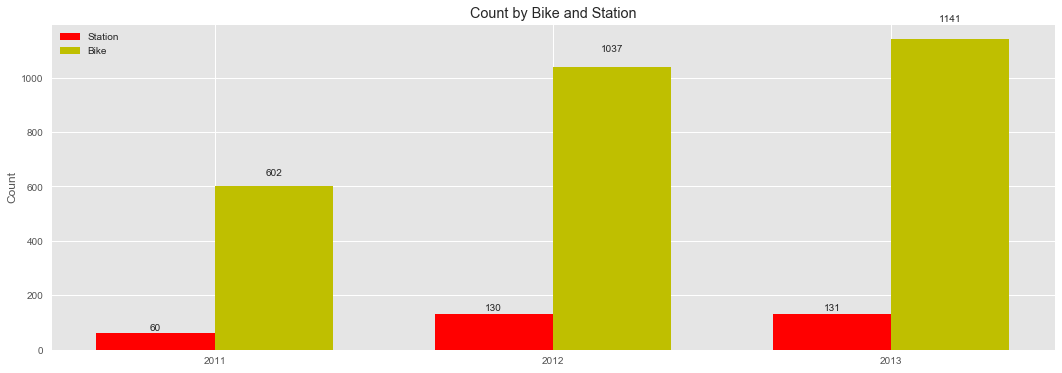

In [14]:
cnt1 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2011][['START_STATION']]))
cnt2 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2012][['START_STATION']]))
cnt3 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2013][['START_STATION']]))

cnt4 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2011][['BIKE_NO']]))
cnt5 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2012][['BIKE_NO']]))
cnt6 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2013][['BIKE_NO']]))

N = 3
station_cnt = (cnt1, cnt2, cnt3)

ind = np.arange(N) 
width = 0.35

fig, ax = plt.subplots(figsize=(18, 6))
rects1 = ax.bar(ind, station_cnt, width, color='r')

bike_cnt = (cnt4, cnt5, cnt6)

rects2 = ax.bar(ind + width, bike_cnt, width, color='y')

ax.set_ylabel('Count')
ax.set_title('Count by Bike and Station')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('2011', '2012', '2013'))

ax.legend((rects1[0], rects2[0]), ('Station', 'Bike'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

#### Importing Daily Weather Data from csv

In [15]:
df21 = pd.read_csv('data/dailyweather.csv',parse_dates=True)

#### Cleaning the dataset

In [16]:
df21.columns = ['CDATE','YEAR','MONTH','DAY','THIGH','TAVG','TLOW','DHIGH','DAVG',
               'DLOW','HHIGH','HAVG','HLOW','PHIGH','PAVG','PLOW','VHIGH','VAVG',
               'VLOW','WHIGH','WAVG','WLOW','PRECIP','EVENT']

dfDailyWeather = df21.copy()

cleanedDate = []
for date in dfDailyWeather['CDATE']:
    if date != None:
        cleanedDate.append(datetime.strptime(date, '%m/%d/%Y'))
    else:
        cleanedDate.append(None)

dfDailyWeather.insert(1, 'DATE', cleanedDate)
dfDailyWeather['DATE'] = dfDailyWeather['DATE'].apply(lambda x: x.date())

dfDailyWeather[['EVENT']] = dfDailyWeather[['EVENT']].fillna(value='Clear')
dfDailyWeather['PRECIP']  = pd.to_numeric(dfDailyWeather['PRECIP'], errors='ignore')
dfDailyWeather['PRECIP']  = dfDailyWeather['PRECIP'].str.replace('T', '0').astype(np.float64)

del dfDailyWeather['YEAR'], dfDailyWeather['MONTH'], dfDailyWeather['DAY'], dfDailyWeather['THIGH']
del dfDailyWeather['TLOW'], dfDailyWeather['DHIGH'], dfDailyWeather['DLOW'], dfDailyWeather['HHIGH']
del dfDailyWeather['HLOW'], dfDailyWeather['PHIGH'], dfDailyWeather['PLOW'], dfDailyWeather['VHIGH']
del dfDailyWeather['VLOW'], dfDailyWeather['WHIGH'], dfDailyWeather['WLOW'], dfDailyWeather['CDATE']

dfDailyWeather.insert(9, 'WEATHER', dfDailyWeather['EVENT'].map(getWeather))

dfDailyWeather.head()

,DATE,TAVG,DAVG,HAVG,PAVG,VAVG,WAVG,PRECIP,EVENT,WEATHER
0,2011-01-01,46,37,73,30.04,9,6,0.00,Clear,1
1,2011-01-02,45,41,85,29.88,5,7,0.15,Rain,3
2,2011-01-03,34,12,48,29.98,10,15,0.00,Clear,1
3,2011-01-04,32,16,52,29.89,10,10,0.00,Clear,1
4,2011-01-05,34,15,49,29.73,10,12,0.00,Clear,1


#### Importing Hourly Weather Data from csv

In [17]:
df22 = pd.read_csv('data/hourlyweather.csv',parse_dates=True)

#### Cleaning the dataset

In [18]:
dfHourlyWeather = df22.copy()

cleanedDate = []
cleanedDate = pd.to_datetime(dfHourlyWeather['dt'],unit='s')

dfHourlyWeather.insert(3, 'START_DATE', cleanedDate)

tempFahrenheit = []
tempFahrenheit = dfHourlyWeather['temp'].map(getFahrenheit).astype(int)
dfHourlyWeather.insert(4, 'TEMP', tempFahrenheit)

dfHourlyWeather = dfHourlyWeather.rename(columns = {'city_id':'CITY', 
                                                    'pressure':'PRESSURE',
                                                    'humidity':'HUMIDITY',
                                                    'wind_speed':'SPEED',
                                                    'rain_1h':'RAIN',
                                                    'snow_1h':'SNOW',
                                                    'weather_main':'WEATHER'})
aTempFahrenheit = []
aTempFahrenheit = dfHourlyWeather.apply(getWindchill, axis=1)
dfHourlyWeather.insert(5, 'ATEMP', aTempFahrenheit)
dfHourlyWeather[['ATEMP']] = round(dfHourlyWeather[['ATEMP']],0).astype(int)

dfHourlyWeather[['RAIN']] = round(dfHourlyWeather[['RAIN']].fillna(value=0),1)
dfHourlyWeather[['SNOW']] = round(dfHourlyWeather[['SNOW']].fillna(value=0),1)

del dfHourlyWeather['dt'],dfHourlyWeather['temp']
del dfHourlyWeather['dt_iso'],dfHourlyWeather['city_name']
del dfHourlyWeather['lat'],dfHourlyWeather['lon'],dfHourlyWeather['PRESSURE']
del dfHourlyWeather['temp_min'],dfHourlyWeather['temp_max']
del dfHourlyWeather['sea_level'],dfHourlyWeather['grnd_level']
del dfHourlyWeather['wind_deg'],dfHourlyWeather['clouds_all']
del dfHourlyWeather['rain_3h'],dfHourlyWeather['rain_24h'],dfHourlyWeather['rain_today']
del dfHourlyWeather['snow_3h'],dfHourlyWeather['snow_24h'],dfHourlyWeather['snow_today']
del dfHourlyWeather['weather_id'],dfHourlyWeather['weather_icon'],dfHourlyWeather['weather_description']

dfHourlyWeather = dfHourlyWeather[dfHourlyWeather['CITY'] == 4930956][['START_DATE','TEMP','ATEMP','HUMIDITY','SPEED','RAIN','SNOW','WEATHER']]

dfHourlyWeather.head()

,START_DATE,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,WEATHER
17754,2012-10-01 13:00:00,57,57,68,3,0.0,0.0,Clear
17755,2012-10-02 14:00:00,59,59,68,3,0.0,0.0,Clear
17756,2012-10-02 15:00:00,62,62,64,3,0.0,0.0,Clear
17757,2012-10-02 16:00:00,62,62,64,4,0.0,0.0,Clear
17758,2012-10-02 17:00:00,63,63,64,4,0.0,0.0,Clear


#### Merging Data

In [19]:
dfTrips['START_DATE'] = dfTrips.START_DATE.dt.round('H')

dfXX = pd.DataFrame(pd.pivot_table(dfTrips, index=['START_DATE'], values='DURATION', aggfunc=np.mean).to_records())
dfYY = pd.DataFrame(pd.pivot_table(dfTrips, index=['START_DATE'], columns=["SUB_TYPE"], values='HID', aggfunc='count').to_records())

dfZZ = pd.merge(dfXX, dfYY, on='START_DATE')
dfZZ = dfZZ.rename(columns = {'Casual':'CASUAL', 'Registered':'REGISTERED'})

dfHourlyRental = pd.merge(dfZZ, dfHourlyWeather, on='START_DATE')

dfHourlyRental[['CASUAL']] = dfHourlyRental[['CASUAL']].fillna(value=0).astype(int)
dfHourlyRental[['REGISTERED']] = dfHourlyRental[['REGISTERED']].fillna(value=0).astype(int)
dfHourlyRental[['DURATION']] = round(dfHourlyRental[['DURATION']]/60,0).astype(int)

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dfHourlyRental['START_DATE'].min(), end=dfHourlyRental['START_DATE'].max()).to_pydatetime()

holiday = []
holiday = dfHourlyRental['START_DATE'].isin(holidays).astype(int)
dfHourlyRental.insert(11, 'HOLIDAY', holiday)

workday = []
workday = ((pd.DatetimeIndex(dfHourlyRental['START_DATE']).dayofweek) // 5 == 1).astype(int)
dfHourlyRental.insert(12, 'WORKDAY', workday)

month = []
month = pd.to_datetime(dfHourlyRental['START_DATE']).dt.month
dfHourlyRental.insert(13, 'MONTH', month)
dfHourlyRental['MONTH'] = dfHourlyRental['MONTH'].apply(lambda x: calendar.month_abbr[x])

weekday = []
weekday = pd.to_datetime(dfHourlyRental['START_DATE']).dt.weekday_name
dfHourlyRental.insert(14, 'WEEKDAY', weekday)

season = []
season = dfHourlyRental['START_DATE'].map(get_season)
dfHourlyRental.insert(15, 'SEASON', season)

dfHourlyRental['WEATHER'] = dfHourlyRental['WEATHER'].map(getWeather)

dfHourlyRental['TOTAL'] = dfHourlyRental['CASUAL'] + dfHourlyRental['REGISTERED']
dfHourlyRental['TOTAL'] = dfHourlyRental['TOTAL'].fillna(value=0).astype(int)

cols = ['START_DATE','SEASON','WEEKDAY','MONTH','HOLIDAY','WORKDAY','TEMP',
        'ATEMP','HUMIDITY','SPEED','RAIN','SNOW','WEATHER','DURATION','CASUAL',
        'REGISTERED','TOTAL']

dfHourlyRental = dfHourlyRental[cols]

dfHourlyRental.head(5)

,START_DATE,SEASON,WEEKDAY,MONTH,HOLIDAY,WORKDAY,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,WEATHER,DURATION,CASUAL,REGISTERED,TOTAL
0,2012-10-01 13:00:00,3,Monday,Oct,0,0,57,57,68,3,0.0,0.0,1,14,30,104,134
1,2012-10-02 14:00:00,3,Tuesday,Oct,0,0,59,59,68,3,0.0,0.0,1,12,36,94,130
2,2012-10-02 15:00:00,3,Tuesday,Oct,0,0,62,62,64,3,0.0,0.0,1,14,26,49,75
3,2012-10-02 16:00:00,3,Tuesday,Oct,0,0,62,62,64,4,0.0,0.0,1,11,17,62,79
4,2012-10-02 17:00:00,3,Tuesday,Oct,0,0,63,63,64,4,0.0,0.0,1,10,20,164,184


#### Variable Type Identification

In [20]:
dfHourlyRental.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6695
Data columns (total 17 columns):
START_DATE    6696 non-null datetime64[ns]
SEASON        6696 non-null int64
WEEKDAY       6696 non-null object
MONTH         6696 non-null object
HOLIDAY       6696 non-null int64
WORKDAY       6696 non-null int64
TEMP          6696 non-null int64
ATEMP         6696 non-null int64
HUMIDITY      6696 non-null int64
SPEED         6696 non-null int64
RAIN          6696 non-null float64
SNOW          6696 non-null float64
WEATHER       6696 non-null int64
DURATION      6696 non-null int64
CASUAL        6696 non-null int64
REGISTERED    6696 non-null int64
TOTAL         6696 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(12), object(2)
memory usage: 941.6+ KB


#### Find missing values in data set if any

In [21]:
null_data = dfHourlyRental[dfHourlyRental.isnull().any(axis=1)]
print(null_data.count)

<bound method DataFrame.count of Empty DataFrame
Columns: [START_DATE, SEASON, WEEKDAY, MONTH, HOLIDAY, WORKDAY, TEMP, ATEMP, HUMIDITY, SPEED, RAIN, SNOW, WEATHER, DURATION, CASUAL, REGISTERED, TOTAL]
Index: []>


#### Basic Data Exploration

Understand the distribution of numerical variables and generate a frequency table for numeric variables.  Now, I’ll test and plot a histogram for each numerical variables and analyze the distribution.

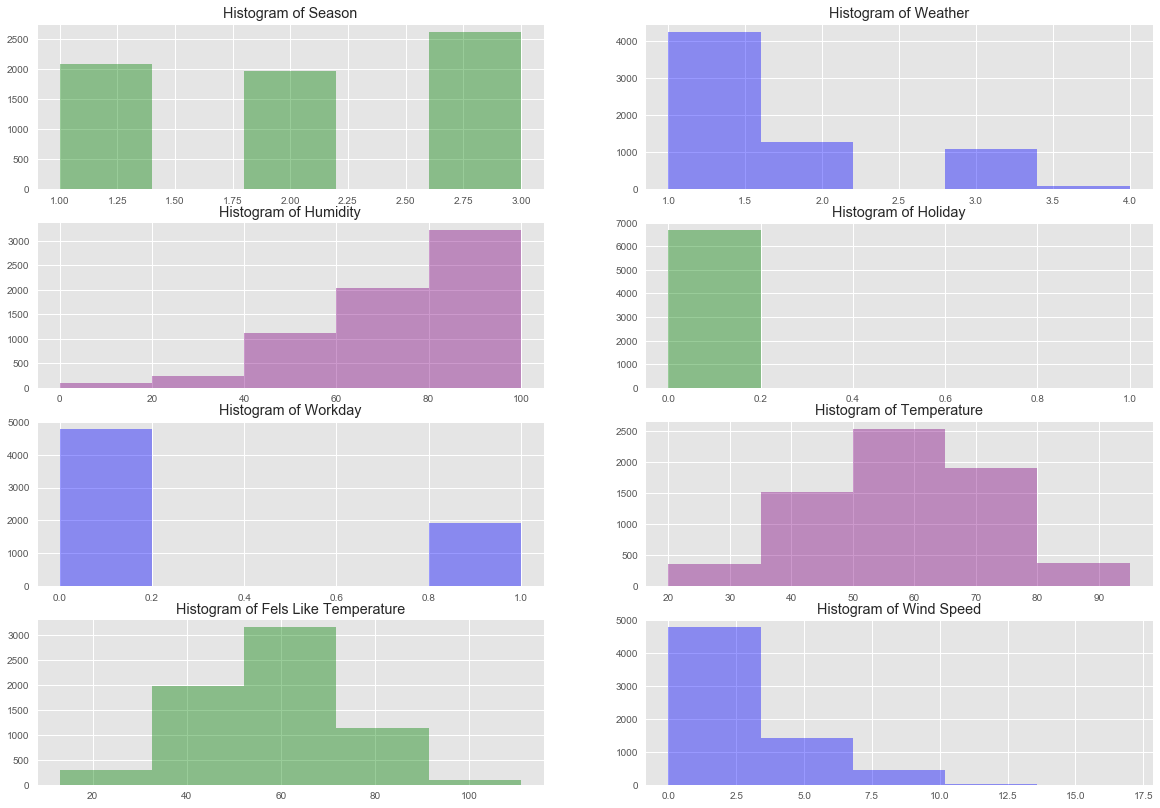

In [22]:
a = dfHourlyRental['SEASON']
b = dfHourlyRental['WEATHER']
c = dfHourlyRental['HUMIDITY']
d = dfHourlyRental['HOLIDAY']
e = dfHourlyRental['WORKDAY']
f = dfHourlyRental['TEMP']
g = dfHourlyRental['ATEMP']
h = dfHourlyRental['SPEED']

fig, ax = plt.subplots(4, 2, figsize=(20, 14))

ax[0, 0].hist(a, bins=5, histtype='bar',color="green",alpha=0.4)
ax[0, 0].set_title("Histogram of Season")

ax[0, 1].hist(b, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[0, 1].set_title("Histogram of Weather")

ax[1, 0].hist(c, bins=5, histtype='bar',color="purple",alpha=0.4)
ax[1, 0].set_title("Histogram of Humidity")

ax[1, 1].hist(d, bins=5, histtype='bar',color="green",alpha=0.4)
ax[1, 1].set_title("Histogram of Holiday")

ax[2, 0].hist(e, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[2, 0].set_title("Histogram of Workday")

ax[2, 1].hist(f, bins=5, histtype='bar',color="purple",alpha=0.4)
ax[2, 1].set_title("Histogram of Temperature")

ax[3, 0].hist(g, bins=5, histtype='bar',color="green",alpha=0.4)
ax[3, 0].set_title("Histogram of Fels Like Temperature")

ax[3, 1].hist(h, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[3, 1].set_title("Histogram of Wind Speed")

plt.show()

Few inferences can be drawn by looking at these histograms:

* Season has three categories and fall has higher contribution
* Weather 1 has higher contribution i.e. mostly clear weather.
* As expected, mostly working days and variable holiday is also showing a similar inference.
* Variables temp, atemp, humidity and windspeed looks naturally distributed.

#### Convert discrete variables into factor (Weekday, Month, Season, holiday, workday, Weather)

In [23]:
categoryVariableList = ["WEEKDAY","MONTH","SEASON","HOLIDAY","WORKDAY","WEATHER"]
for var in categoryVariableList:
    dfHourlyRental[var] = dfHourlyRental[var].astype("category")

In [24]:
dfHourlyRental.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6695
Data columns (total 17 columns):
START_DATE    6696 non-null datetime64[ns]
SEASON        6696 non-null category
WEEKDAY       6696 non-null category
MONTH         6696 non-null category
HOLIDAY       6696 non-null category
WORKDAY       6696 non-null category
TEMP          6696 non-null int64
ATEMP         6696 non-null int64
HUMIDITY      6696 non-null int64
SPEED         6696 non-null int64
RAIN          6696 non-null float64
SNOW          6696 non-null float64
WEATHER       6696 non-null category
DURATION      6696 non-null int64
CASUAL        6696 non-null int64
REGISTERED    6696 non-null int64
TOTAL         6696 non-null int64
dtypes: category(6), datetime64[ns](1), float64(2), int64(8)
memory usage: 668.2 KB


#### Lets Start With Very Simple Visualization Of Variables DataType Count

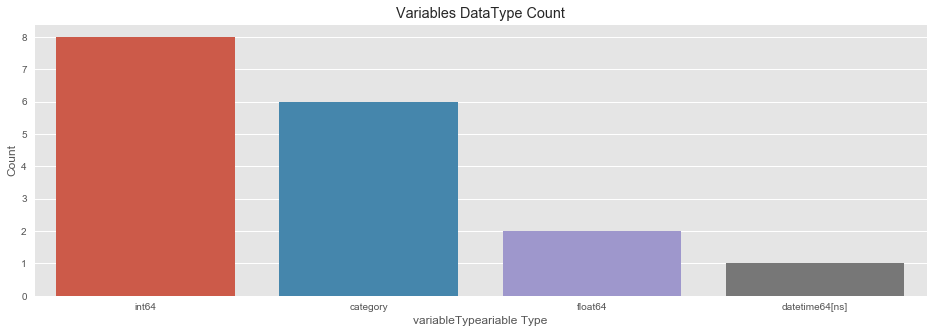

In [25]:
dataTypeDf = pd.DataFrame(dfHourlyRental.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(16,5)
sns.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

plt.show()

### Hypothesis Testing (using multivariate analysis)

#### Hourly trend: 
We don’t have the variable ‘hour’ with us right now. But we can extract it using the datetime column.

In [26]:
hour = []
hour = pd.to_datetime(dfHourlyRental['START_DATE']).dt.hour
dfHourlyRental.insert(2, 'HOUR', hour)

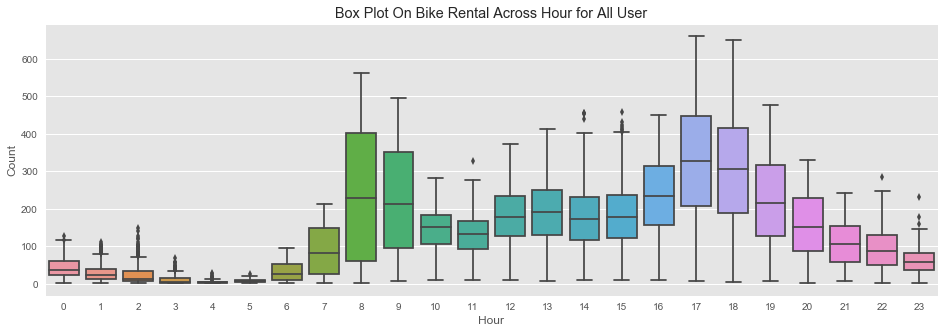

In [93]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="TOTAL",x="HOUR",orient="v",ax=axes)

axes.set(xlabel='Hour', ylabel='Count',title="Box Plot On Bike Rental Across Hour for All User")

plt.show()

Above, we can see the trend of bike demand over hours and segregate the bike demand in three categories:

High       : 7-9 and 17-20 hours

Average  : 10-16 hours

Low         : 0-6 and 21-24 hours

Here I have analyzed the distribution of total bike demand. Let’s look at the distribution of registered and casual users separately.

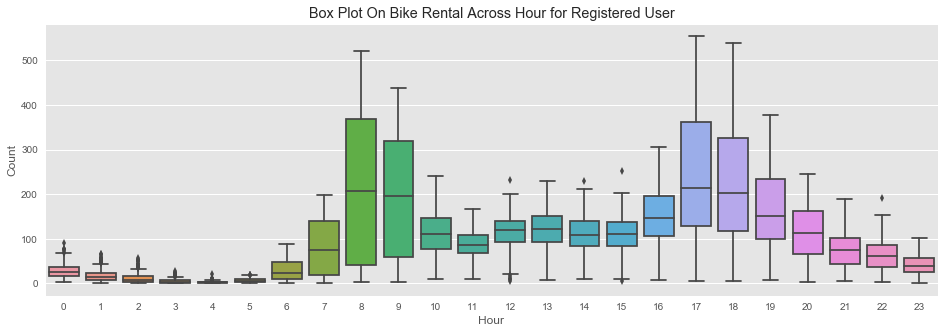

In [28]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="REGISTERED",x="HOUR",orient="v",ax=axes)

axes.set(xlabel='Hour', ylabel='Count',title="Box Plot On Bike Rental Across Hour for Registered User")

plt.show()

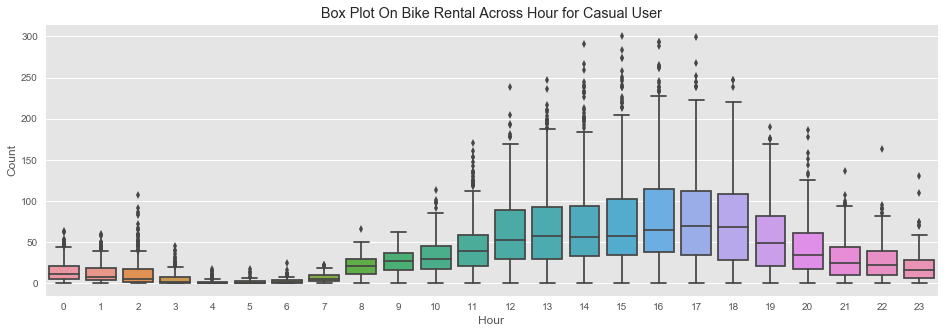

In [29]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="CASUAL",x="HOUR",orient="v",ax=axes)

axes.set(xlabel='Hour', ylabel='Count',title="Box Plot On Bike Rental Across Hour for Casual User")

plt.show()

Above we can see that registered users have similar trend as count. Whereas, casual users have different trend. Thus, we can say that ‘hour’ is significant variable and our hypothesis is ‘true’.

#### Daily Trend: 
Like Hour, we will generate a variable for day from datetime variable and after that we’ll plot it.

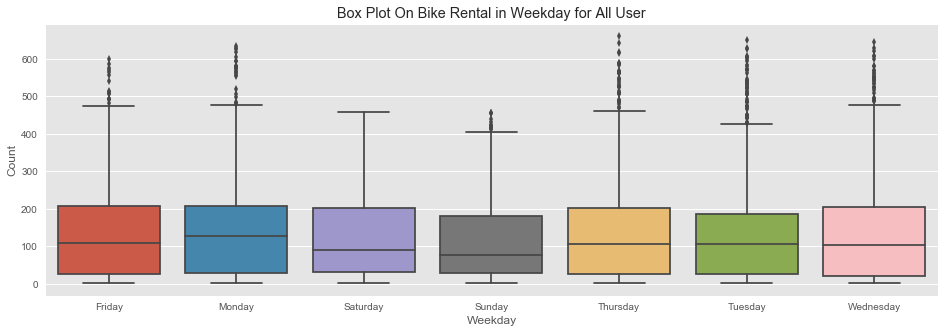

In [92]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="TOTAL",x="WEEKDAY",orient="v",ax=axes)

axes.set(xlabel='Weekday', ylabel='Count',title="Box Plot On Bike Rental in Weekday for All User")

plt.show()

Plot shows registered and casual users’ demand over days.

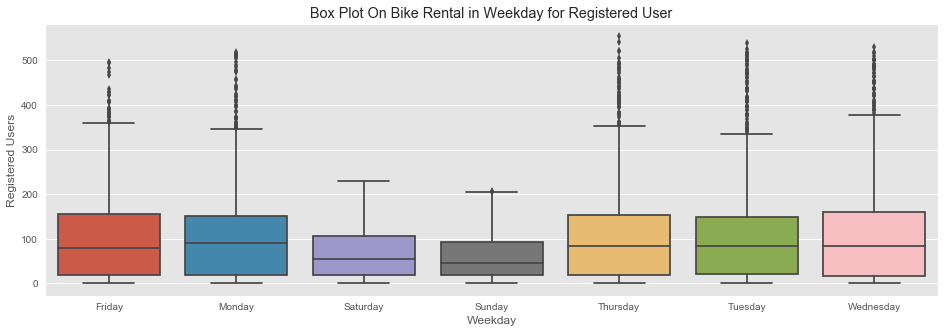

In [31]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="REGISTERED",x="WEEKDAY",orient="v",ax=axes)

axes.set(xlabel='Weekday', ylabel='Registered Users',title="Box Plot On Bike Rental in Weekday for Registered User")

plt.show()

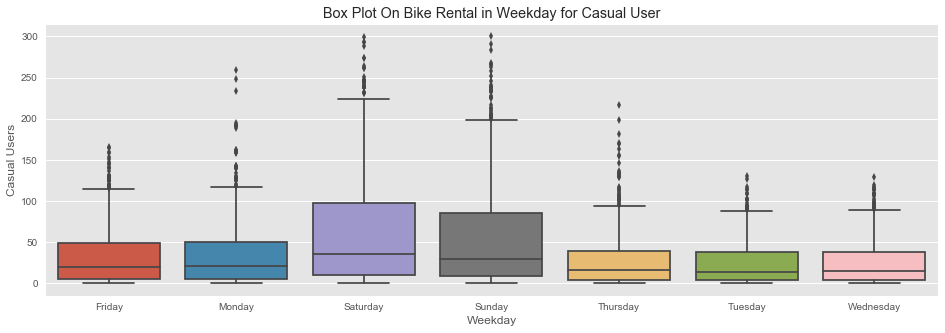

In [32]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="CASUAL",x="WEEKDAY",orient="v",ax=axes)

axes.set(xlabel='Weekday', ylabel='Casual Users',title="Box Plot On Bike Rental in Weekday for Casual User")

plt.show()

While looking at the plot, I can say that the demand of causal users increases over weekend.

##### Rain: 
We don’t have the ‘rain’ variable with us but have ‘weather’ which is sufficient to test our hypothesis. As per variable description, weather 2 represents drizzle and weather 3 represents heavy rain. Take a look at the plot:

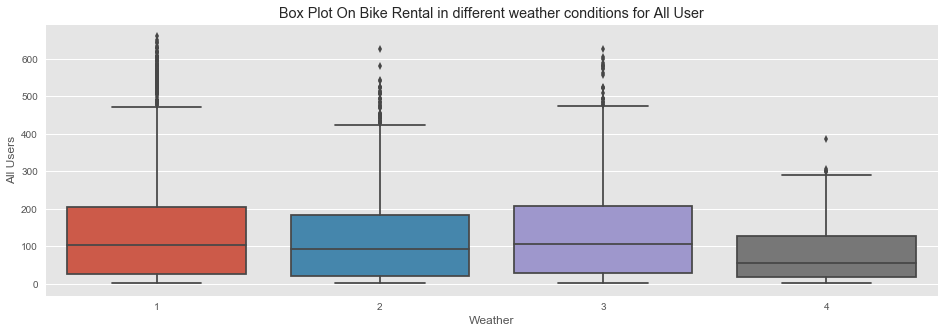

In [91]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="TOTAL",x="WEATHER",orient="v",ax=axes)

axes.set(xlabel='Weather', ylabel='All Users',title="Box Plot On Bike Rental in different weather conditions for All User")

plt.show()

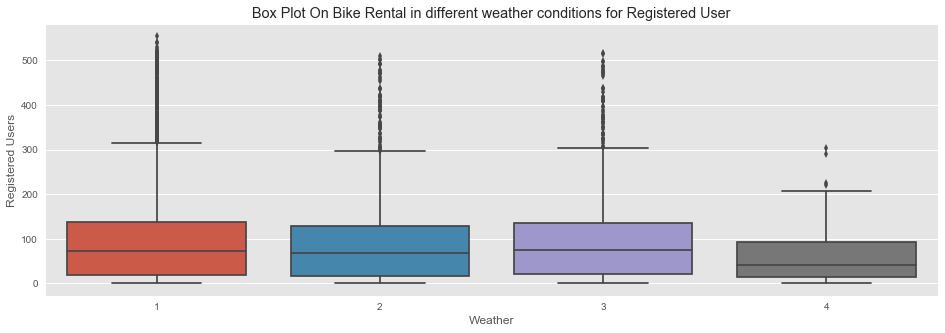

In [33]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="REGISTERED",x="WEATHER",orient="v",ax=axes)

axes.set(xlabel='Weather', ylabel='Registered Users',title="Box Plot On Bike Rental in different weather conditions for Registered User")

plt.show()

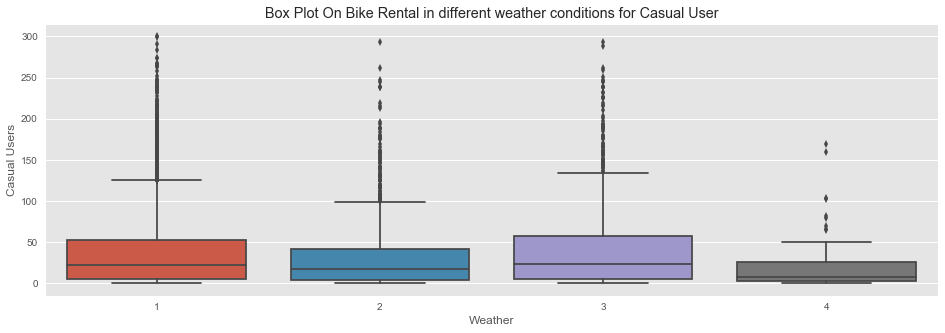

In [34]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="CASUAL",x="WEATHER",orient="v",ax=axes)

axes.set(xlabel='Weather', ylabel='Casual Users',title="Box Plot On Bike Rental in different weather conditions for Casual User")

plt.show()

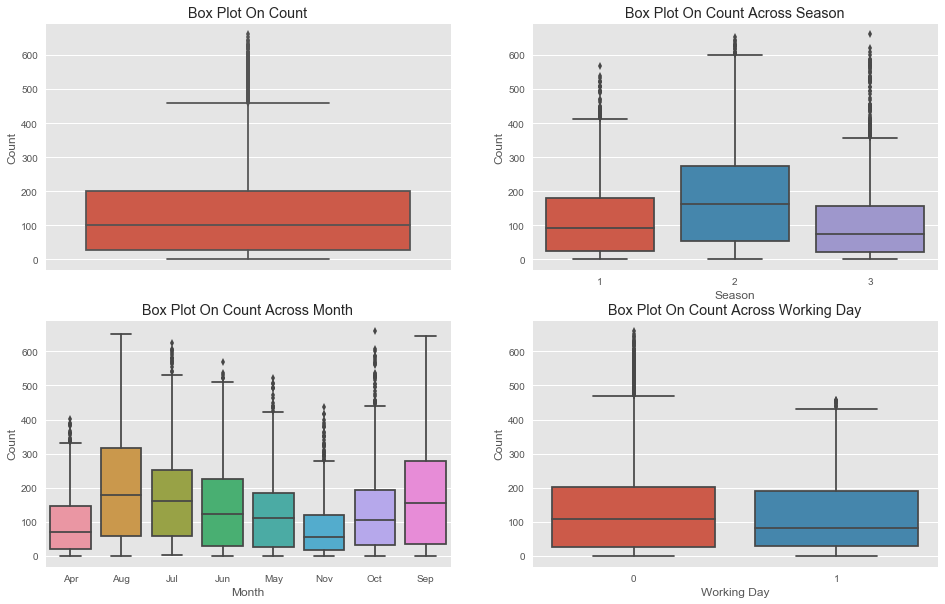

In [35]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16, 10)
sns.boxplot(data=dfHourlyRental,y="TOTAL",orient="v",ax=axes[0][0])
sns.boxplot(data=dfHourlyRental,y="TOTAL",x="SEASON",orient="v",ax=axes[0][1])
sns.boxplot(data=dfHourlyRental,y="TOTAL",x="MONTH",orient="v",ax=axes[1][0])
sns.boxplot(data=dfHourlyRental,y="TOTAL",x="WORKDAY",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Month")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

plt.show()

##### Temperature, Windspeed and Humidity: 
These are continuous variables so we can look at the correlation factor to validate hypothesis.

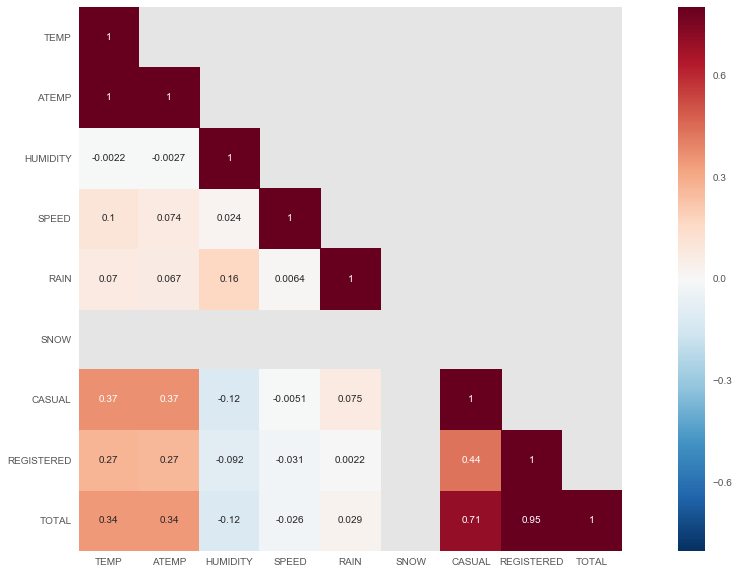

In [36]:
corrMatt = dfHourlyRental[['TEMP','ATEMP','HUMIDITY','SPEED','RAIN','SNOW','CASUAL','REGISTERED', 'TOTAL']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

plt.show()

Here are a few inferences you can draw by looking at the above histograms:

* Variable temp is positively correlated with dependent variables (casual is more compare to registered)
* Variable atemp is highly correlated with temp.
* Windspeed has lower correlation as compared to temp and humidity

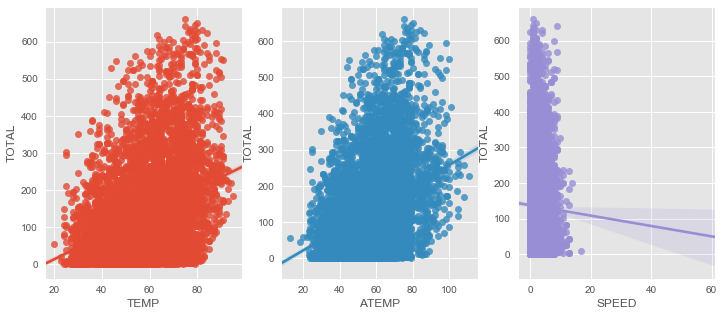

In [37]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="TEMP", y="TOTAL", data=dfHourlyRental,ax=ax1)
sns.regplot(x="ATEMP", y="TOTAL", data=dfHourlyRental,ax=ax2)
sns.regplot(x="SPEED", y="TOTAL", data=dfHourlyRental,ax=ax3)

plt.show()

##### Pollution & Traffic: 
We don’t have the variable related with these metrics in our data set so we cannot test this hypothesis.

##### Visualizing Distribution Of Data

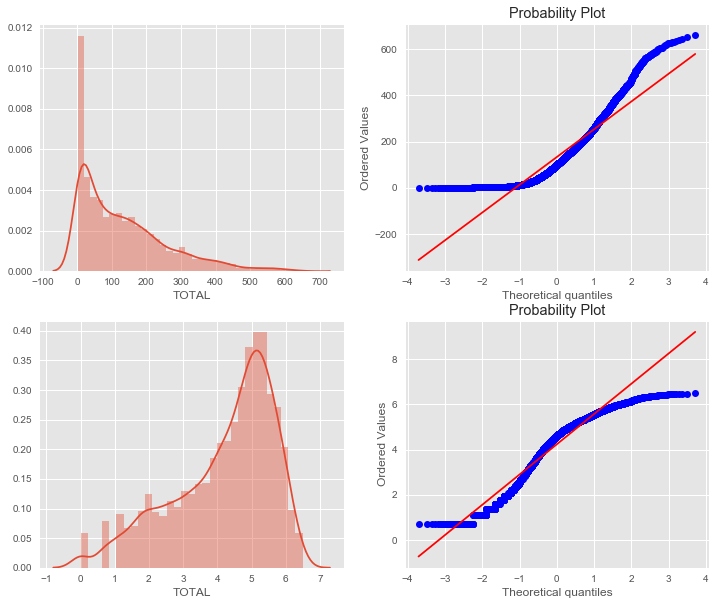

In [38]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(dfHourlyRental["TOTAL"],ax=axes[0][0])
stats.probplot(dfHourlyRental["TOTAL"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(dfHourlyRental["TOTAL"]),ax=axes[1][0])
stats.probplot(np.log1p(dfHourlyRental["TOTAL"]), dist='norm', fit=True, plot=axes[1][1])
plt.show()

##### Visualizing Total Bike Rental Per Month

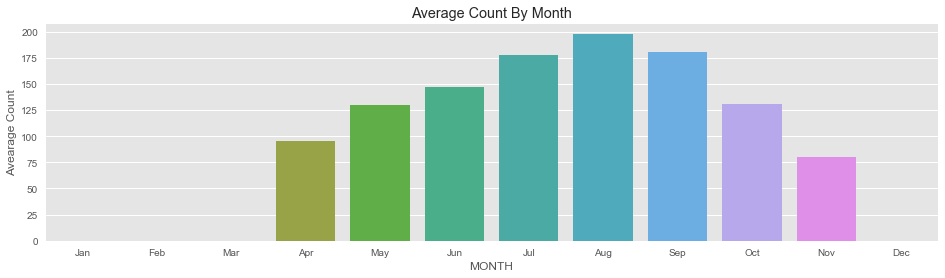

In [72]:
fig,ax1 = plt.subplots()
fig.set_size_inches(16,4)
sortOrder = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

monthAggregated = pd.DataFrame(dfHourlyRental.groupby("MONTH")["TOTAL"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="TOTAL",ascending=False)
sns.barplot(data=monthSorted,x="MONTH",y="TOTAL",ax=ax1,order=sortOrder)
ax1.set(xlabel='MONTH', ylabel='Avearage Count',title="Average Count By Month")

plt.show()

In [73]:
dfHourlyRental.head(1)

,START_DATE,SEASON,HOUR,WEEKDAY,MONTH,HOLIDAY,WORKDAY,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,WEATHER,DURATION,CASUAL,REGISTERED,TOTAL
0,2012-10-01 13:00:00,3,13,Monday,Oct,0,0,57,57,68,3,0.0,0.0,1,14,30,104,134


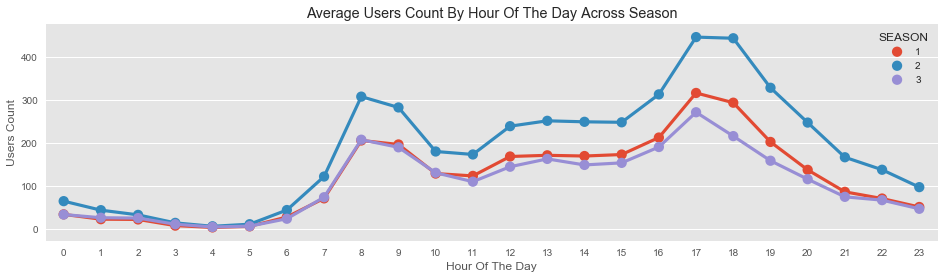

In [79]:
fig,ax2 = plt.subplots()
fig.set_size_inches(16,4)

hourAggregated = pd.DataFrame(dfHourlyRental.groupby(["HOUR","SEASON"],sort=True)["TOTAL"].mean()).reset_index()
sns.pointplot(x=hourAggregated["HOUR"], y=hourAggregated["TOTAL"],hue=hourAggregated["SEASON"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

plt.show()

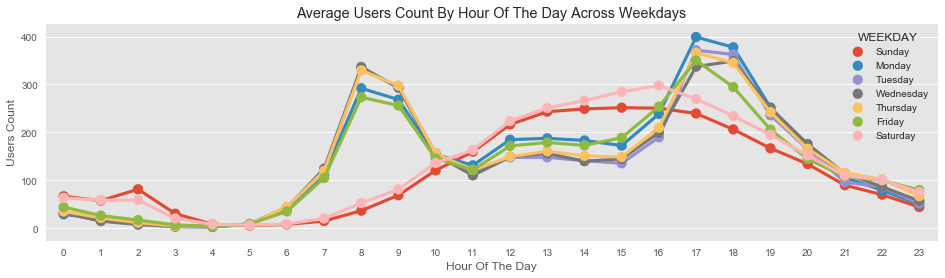

In [83]:
fig,ax3 = plt.subplots()
fig.set_size_inches(16,4)
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

hourAggregated = pd.DataFrame(dfHourlyRental.groupby(["HOUR","WEEKDAY"],sort=True)["TOTAL"].mean()).reset_index()
sns.pointplot(x=hourAggregated["HOUR"], y=hourAggregated["TOTAL"],hue=hourAggregated["WEEKDAY"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

plt.show()

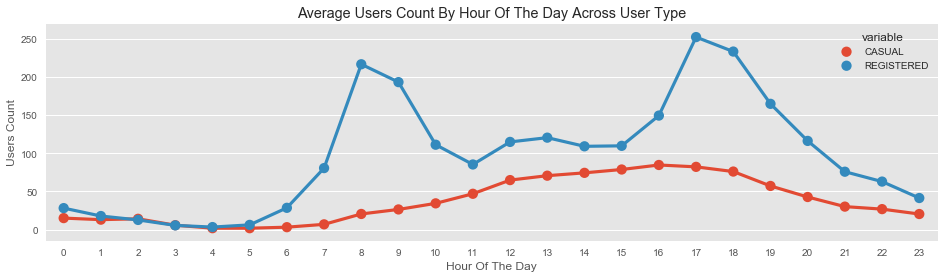

In [90]:
fig,ax4 = plt.subplots()
fig.set_size_inches(16,4)

hourTransformed = pd.melt(dfHourlyRental[["HOUR","CASUAL","REGISTERED"]], id_vars=['HOUR'], value_vars=['CASUAL', 'REGISTERED'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["HOUR","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["HOUR"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["CASUAL","REGISTERED"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

plt.show()

### Feature Engineering

##### Dropping Unncessary Columns

In [40]:
dropFeatures = ["DURATION","CASUAL","TOTAL","START_DATE","REGISTERED"]
dfHourly  = dfHourlyRental.drop(dropFeatures,axis=1)

dfHourly.head(5)

,SEASON,HOUR,WEEKDAY,MONTH,HOLIDAY,WORKDAY,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,WEATHER
0,3,13,Monday,Oct,0,0,57,57,68,3,0.0,0.0,1
1,3,14,Tuesday,Oct,0,0,59,59,68,3,0.0,0.0,1
2,3,15,Tuesday,Oct,0,0,62,62,64,3,0.0,0.0,1
3,3,16,Tuesday,Oct,0,0,62,62,64,4,0.0,0.0,1
4,3,17,Tuesday,Oct,0,0,63,63,64,4,0.0,0.0,1


In [41]:
dfHourly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6695
Data columns (total 13 columns):
SEASON      6696 non-null category
HOUR        6696 non-null int64
WEEKDAY     6696 non-null category
MONTH       6696 non-null category
HOLIDAY     6696 non-null category
WORKDAY     6696 non-null category
TEMP        6696 non-null int64
ATEMP       6696 non-null int64
HUMIDITY    6696 non-null int64
SPEED       6696 non-null int64
RAIN        6696 non-null float64
SNOW        6696 non-null float64
WEATHER     6696 non-null category
dtypes: category(6), float64(2), int64(5)
memory usage: 779.0 KB


##### Independent Variables

* datetime:   date and hour in "mm/dd/yyyy hh:mm" format
* season:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday:    whether the day is a holiday or not (1/0)
* workingday: whether the day is neither a weekend nor holiday (1/0)
* weather:    Four Categories of weather
            1. Clear, Clouds
            2. Mist, Drizzle, Fog
            3. Rain, Haze
            4. Snow, Thunderstorm, Squall
* temp:       hourly temperature in Fahrenheit
* atemp:      "feels like" temperature in Fahrenheit
* humidity:   relative humidity
* windspeed:  wind speed

##### Dependent Variables

* Registered: number of registered user
* Casual:     number of non-registered user
* Casual:     number of total rentals (registered + casual)

In [42]:
dfRental = pd.get_dummies(dfHourly, columns=['SEASON','HOUR','WEEKDAY','MONTH','HOLIDAY','WORKDAY','WEATHER'])

dfRental.head(5)

,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,SEASON_1,SEASON_2,SEASON_3,HOUR_0,...,MONTH_Oct,MONTH_Sep,HOLIDAY_0,HOLIDAY_1,WORKDAY_0,WORKDAY_1,WEATHER_1,WEATHER_2,WEATHER_3,WEATHER_4
0,57,57,68,3,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
1,59,59,68,3,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
2,62,62,64,3,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
3,62,62,64,4,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
4,63,63,64,4,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0


In [43]:
dfRental.rename(columns={'WEEKDAY_Friday':'FRIDAY', 
                         'WEEKDAY_Monday':'MONDAY',
                         'WEEKDAY_Saturday': 'SATURDAY',
                         'WEEKDAY_Sunday': 'SUNDAY',
                         'WEEKDAY_Thursday': 'THURSDAY',
                         'WEEKDAY_Tuesday': 'TUESDAY',
                         'WEEKDAY_Wednesday': 'WEDNESDAY',
                         'MONTH_Apr': 'APR',
                         'MONTH_Aug': "AUG",
                         'MONTH_Jul': 'JUL',
                         'MONTH_Jun': 'JUN',
                         'MONTH_May': 'MAY',
                         'MONTH_Nov': 'NOV',
                         'MONTH_Oct': 'OCT',
                         'MONTH_Sep': 'SEP',
                         'SEASON_1': 'SPRING',
                         'SEASON_2': 'SUMMER',
                         'SEASON_3': 'FALL',
                         'HOUR_0': '12AM',      
                         'HOUR_1': '01AM',      
                         'HOUR_2': '02AM',     
                         'HOUR_3': '03AM',      
                         'HOUR_4': '04AM',      
                         'HOUR_5': '05AM',      
                         'HOUR_6': '06AM',      
                         'HOUR_7': '07AM',      
                         'HOUR_8': '08AM',      
                         'HOUR_9': '09AM',      
                         'HOUR_10': '10AM',     
                         'HOUR_11': '11AM',     
                         'HOUR_12': '12PM',     
                         'HOUR_13': '01PM',     
                         'HOUR_14': '02PM',     
                         'HOUR_15': '03PM',     
                         'HOUR_16': '04PM',     
                         'HOUR_17': '05PM',     
                         'HOUR_18': '06PM',     
                         'HOUR_19': '07PM',     
                         'HOUR_20': '08PM',     
                         'HOUR_21': '09PM',     
                         'HOUR_22': '10PM',     
                         'HOUR_23': '11PM',
                         'WEATHER_1': 'CLEAR',
                         'WEATHER_2': 'DRIZZLE',
                         'WEATHER_3': 'RAIN',
                         'WEATHER_4': 'STORM',
                         'HOLIDAY_0': 'WORKDAY',
                         'HOLIDAY_1': 'HOLIDAY',
                         'WORKDAY_0': 'WEEKEND',
                         'WORKDAY_1': 'WEEKDAY'
                      }, inplace=True)

In [44]:
dfRental.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6695
Data columns (total 56 columns):
TEMP         6696 non-null int64
ATEMP        6696 non-null int64
HUMIDITY     6696 non-null int64
SPEED        6696 non-null int64
RAIN         6696 non-null float64
SNOW         6696 non-null float64
SPRING       6696 non-null uint8
SUMMER       6696 non-null uint8
FALL         6696 non-null uint8
12AM         6696 non-null uint8
01AM         6696 non-null uint8
02AM         6696 non-null uint8
03AM         6696 non-null uint8
04AM         6696 non-null uint8
05AM         6696 non-null uint8
06AM         6696 non-null uint8
07AM         6696 non-null uint8
08AM         6696 non-null uint8
09AM         6696 non-null uint8
10AM         6696 non-null uint8
11AM         6696 non-null uint8
12PM         6696 non-null uint8
01PM         6696 non-null uint8
02PM         6696 non-null uint8
03PM         6696 non-null uint8
04PM         6696 non-null uint8
05PM         6696 non-null uint

##### Linear Regression Model - Registered User

           estimatedCoefficients
TEMP                1.412235e+00
ATEMP              -6.147998e-01
HUMIDITY           -1.114383e-01
SPEED              -2.473638e+00
RAIN                2.681859e-01
SNOW                6.242222e+16
SPRING              6.502507e+14
SUMMER              6.502507e+14
FALL                6.502507e+14
12AM               -2.107571e+14
01AM               -2.107571e+14
02AM               -2.107571e+14
03AM               -2.107571e+14
04AM               -2.107571e+14
05AM               -2.107571e+14
06AM               -2.107571e+14
07AM               -2.107571e+14
08AM               -2.107571e+14
09AM               -2.107571e+14
10AM               -2.107571e+14
11AM               -2.107571e+14
12PM               -2.107571e+14
01PM               -2.107571e+14
02PM               -2.107571e+14
03PM               -2.107571e+14
04PM               -2.107571e+14
05PM               -2.107571e+14
06PM               -2.107571e+14
07PM               -2.107571e+14
08PM      

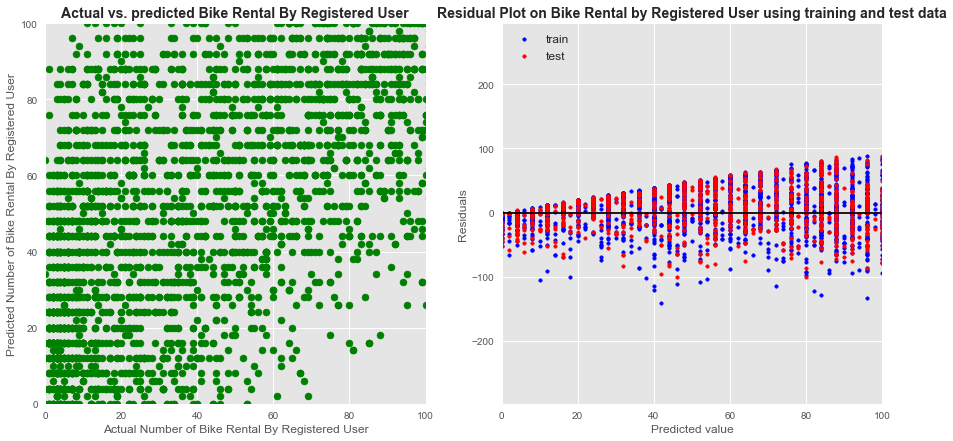

MSE: 3809.23 
SE: 233.01


In [45]:
X = dfRental
y = dfHourlyRental['REGISTERED']

#Need to normalize due to wide variance between features
lmReg = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#Fit on training data
model = lmReg.fit(X_train, y_train)

#Look at coefficients of the model
print(pd.DataFrame(lmReg.coef_, index = X.columns, columns = ['estimatedCoefficients']))

lmRegScore = round(lmReg.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by registered user using Linear Regression prediction {}'.format(lmRegScore))

lmMseTrnReg = round(np.mean((lmReg.predict(X_train) - y_train) **2),2)
lmMseTstReg = round(np.mean((lmReg.predict(X_test) - y_test) ** 2),2)

print('MSE for training response data: {:.2f}'.format(lmMseTrnReg))
print('MSE for test response data: {:.2f}'.format(lmMseTstReg))

fig = plt.figure(figsize=(15,7))

#Plot actual vs. predicted on number of Bike Rental
plt.subplot(1,2,1)
plt.scatter(y, lmReg.predict(X), c='g');
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Actual Number of Bike Rental By Registered User', fontsize = 12);
plt.ylabel('Predicted Number of Bike Rental By Registered User', fontsize = 12);
plt.title('Actual vs. predicted Bike Rental By Registered User', fontsize = 14, fontweight = 'bold');

#Plot residuals of number of Bike Rental
plt.subplot(1,2,2)
plt.scatter(lmReg.predict(X_train), lmReg.predict(X_train) - y_train, c='b', marker = '.', label = 'train')
plt.scatter(lmReg.predict(X_test), lmReg.predict(X_test) - y_test, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=0, xmax = 100)
plt.title('Residual Plot on Bike Rental by Registered User using training and test data', fontsize = 14, fontweight = 'bold');
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,100]);
plt.legend(fontsize = 12, loc = 2)

plt.show()

#Using K-folds and cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle = True)
lmRegCv = LinearRegression(normalize = True)

#Find MSE on response time prediction
scores = cross_val_score(lmRegCv, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

##### Random Forest Model - Registered User

Test R2 on demand for bike rental by registered user using Random Forest prediction 0.81
MSE for training response data: 426.87
MSE for test response data: 2138.91


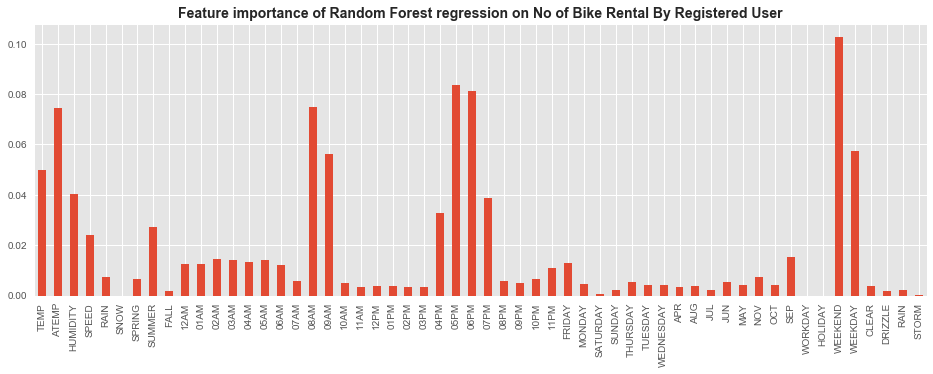

MSE: 2245.737236015397 
SE: 66.98636450528498


In [46]:
X = dfRental
y = dfHourlyRental['REGISTERED']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

rf_registered = RandomForestRegressor(random_state = 0)

rf_registered.fit(X_train, y_train)

rfRegScore = round(rf_registered.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by registered user using Random Forest prediction {}'.format(rfRegScore))

rfMseTrnReg = round(np.mean((rf_registered.predict(X_train) - y_train) **2),2)
rfMseTstReg = round(np.mean((rf_registered.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(rfMseTrnReg))
print('MSE for test response data: {:.2f}'.format(rfMseTstReg))

registered_features = pd.Series(rf_registered.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(16,5));
registered_features.plot(kind = 'bar');
plt.title('Feature importance of Random Forest regression on No of Bike Rental By Registered User', fontsize = 14, fontweight = 'bold');

plt.show()

#Find MSE on number of Bike Rental prediction using 5 K-folds for Registered User
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(5, shuffle = True)
scores = cross_val_score(rf_registered, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

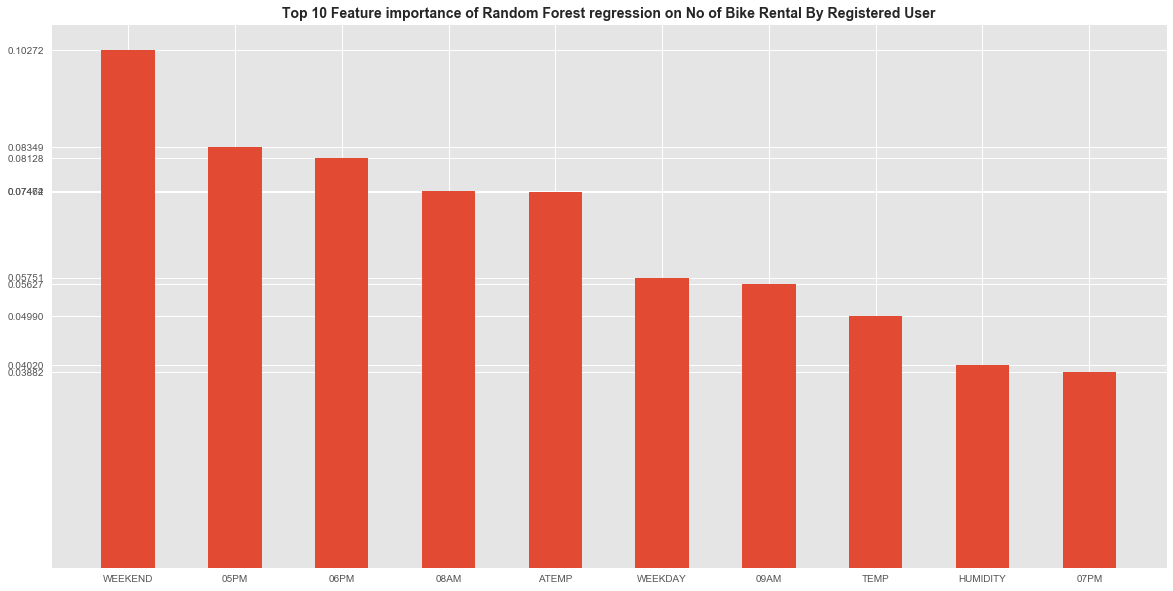

In [47]:
feature = rf_registered.feature_importances_.tolist()
columns = X.columns.tolist()
featureimportancesList = list(zip(columns,feature))
sortedfeatureimportancesList = sorted(featureimportancesList,key=lambda x: x[1], reverse=True)
top=sortedfeatureimportancesList[:10]

fig = plt.figure(figsize=(20, 10))

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.5

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.title('Top 10 Feature importance of Random Forest regression on No of Bike Rental By Registered User', fontsize = 14, fontweight = 'bold');

plt.show()

##### Gradient Boosting Model - Registered User

Test R2 on demand for bike rental by registered user using Gradient Boosting prediction 0.85
MSE for training response data: 231.38
MSE for test response data: 1669.31


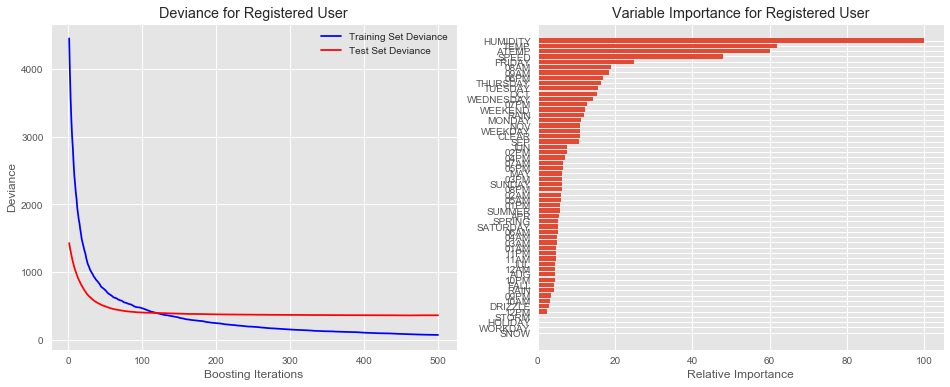

MSE: 1808.8698451584055 
SE: 271.3144758107008


In [48]:
X = dfRental
y = dfHourlyRental['REGISTERED']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gb_registered = GradientBoostingRegressor(**params).fit(X_train, y_train)

mse = mean_squared_error(y_test, gb_registered.predict(X_test))
r2 = r2_score(y_test, gb_registered.predict(X_test))

gbRegScore = round(gb_registered.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by registered user using Gradient Boosting prediction {}'.format(gbRegScore))

gbMseTrnReg = round(np.mean((gb_registered.predict(X_train) - y_train) **2),2)
gbMseTstReg = round(np.mean((gb_registered.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(gbMseTrnReg))
print('MSE for test response data: {:.2f}'.format(gbMseTstReg))

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gb_registered.staged_predict(X_test)):
    test_score[i] = gb_registered.loss_(y_test, y_pred)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance for Registered User')
plt.plot(np.arange(params['n_estimators']) + 1, gb_registered.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

feature_importance = gb_registered.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for Registered User')
plt.show()

#Find MSE on No Of Bike Rental prediction using 5 K-folds for Registered User
kf = KFold(5, shuffle = True)
scores = cross_val_score(gb_registered, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

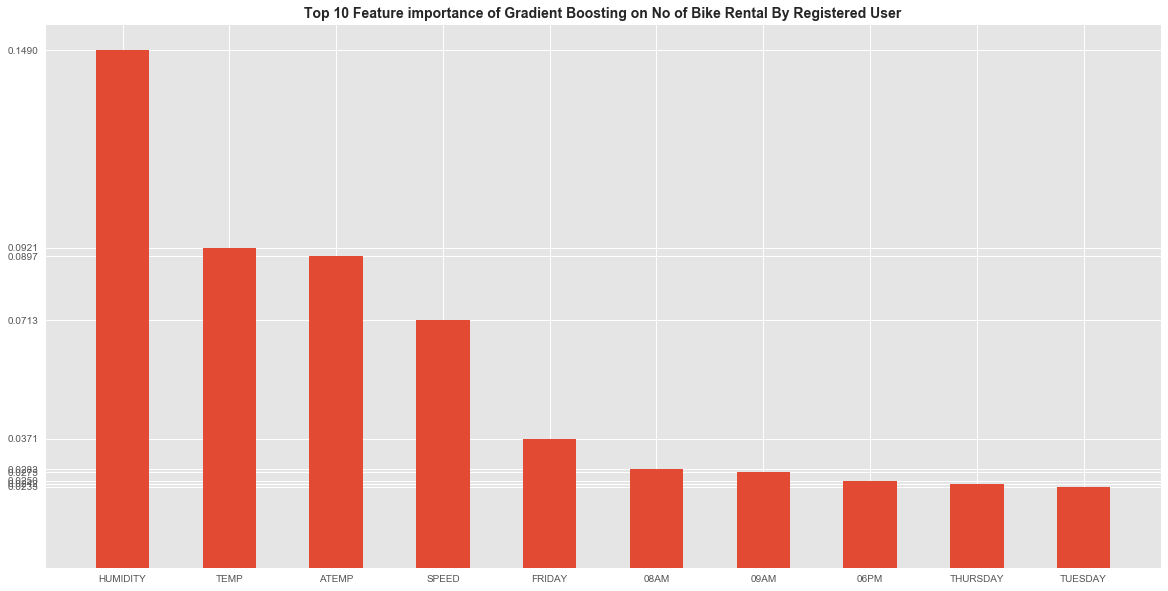

In [49]:
feature = gb_registered.feature_importances_.tolist()
columns = X.columns.tolist()
featureimportancesList = list(zip(columns,feature))
sortedfeatureimportancesList = sorted(featureimportancesList,key=lambda x: x[1], reverse=True)
top=sortedfeatureimportancesList[:10]

fig = plt.figure(figsize=(20, 10))

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.5

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.title('Top 10 Feature importance of Gradient Boosting on No of Bike Rental By Registered User', fontsize = 14, fontweight = 'bold');

plt.show()

##### Linear Regression Model - Casual User

           estimatedCoefficients
TEMP               -1.343635e+00
ATEMP               1.410623e+00
HUMIDITY           -2.474520e-02
SPEED              -7.813897e-01
RAIN                1.536406e+00
SNOW                2.037143e+16
SPRING              1.782800e+14
SUMMER              1.782800e+14
FALL                1.782800e+14
12AM               -6.259825e+13
01AM               -6.259825e+13
02AM               -6.259825e+13
03AM               -6.259825e+13
04AM               -6.259825e+13
05AM               -6.259825e+13
06AM               -6.259825e+13
07AM               -6.259825e+13
08AM               -6.259825e+13
09AM               -6.259825e+13
10AM               -6.259825e+13
11AM               -6.259825e+13
12PM               -6.259825e+13
01PM               -6.259825e+13
02PM               -6.259825e+13
03PM               -6.259825e+13
04PM               -6.259825e+13
05PM               -6.259825e+13
06PM               -6.259825e+13
07PM               -6.259825e+13
08PM      

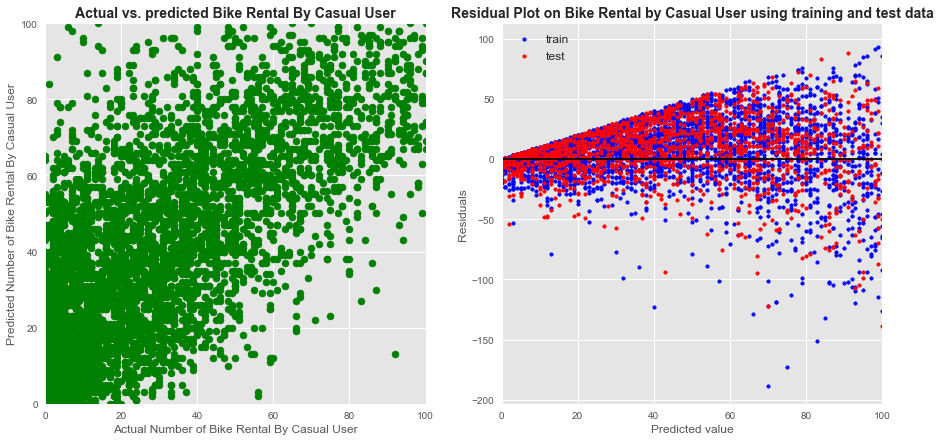

MSE: 916.61 
SE: 63.32


In [50]:
X = dfRental
y = dfHourlyRental['CASUAL']

#Need to normalize due to wide variance between features
lmCas = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#Fit on training data
model = lmCas.fit(X_train, y_train)

#Look at coefficients of the model
print(pd.DataFrame(lmCas.coef_, index = X.columns, columns = ['estimatedCoefficients']))

lmCasScore = round(lmCas.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by casual user using Linear Regression prediction {}'.format(lmCasScore))

lmMseTrnCas = round(np.mean((lmCas.predict(X_train) - y_train) **2),2)
lmMseTstCas = round(np.mean((lmCas.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(lmMseTrnCas))
print('MSE for test response data: {:.2f}'.format(lmMseTstCas))

fig = plt.figure(figsize=(15,7))

#Plot actual vs. predicted on number of Bike Rental
plt.subplot(1,2,1)
plt.scatter(y, lmCas.predict(X), c='g');
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Actual Number of Bike Rental By Casual User', fontsize = 12);
plt.ylabel('Predicted Number of Bike Rental By Casual User', fontsize = 12);
plt.title('Actual vs. predicted Bike Rental By Casual User', fontsize = 14, fontweight = 'bold');

#Plot residuals of number of Bike Rental
plt.subplot(1,2,2)
plt.scatter(lmCas.predict(X_train), lmCas.predict(X_train) - y_train, c='b', marker = '.', label = 'train')
plt.scatter(lmCas.predict(X_test), lmCas.predict(X_test) - y_test, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=0, xmax = 100)
plt.title('Residual Plot on Bike Rental by Casual User using training and test data', fontsize = 14, fontweight = 'bold');
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,100]);
plt.legend(fontsize = 12, loc = 2)

plt.show()

#Using K-folds and cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle = True)
lmCasCv = LinearRegression(normalize = True)

#Find MSE on number of Bike Rental prediction
scores = cross_val_score(lmCasCv, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

##### Random Forest Model - Casual User

Test R2 on demand for bike rental by casual user using Random Forest prediction 0.76
MSE for training response data: 105.17
MSE for test response data: 536.22


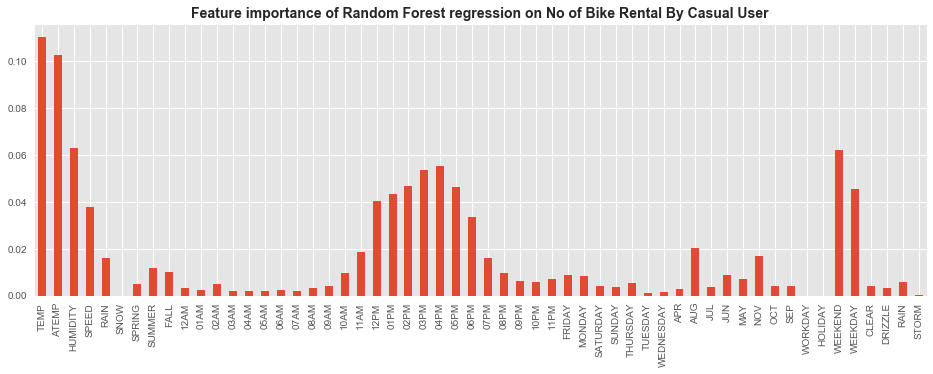

MSE: 619.3010440222527 
SE: 84.91916237437744


In [51]:
X = dfRental
y = dfHourlyRental['CASUAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

rf_casual = RandomForestRegressor(random_state = 0)

rf_casual.fit(X_train, y_train)

rfCasScore = round(rf_casual.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by casual user using Random Forest prediction {}'.format(rfCasScore))

rfMseTrnCas = round(np.mean((rf_casual.predict(X_train) - y_train) **2),2)
rfMseTstCas = round(np.mean((rf_casual.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(rfMseTrnCas))
print('MSE for test response data: {:.2f}'.format(rfMseTstCas))

casual_features = pd.Series(rf_casual.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(16,5));
casual_features.plot(kind = 'bar');
plt.title('Feature importance of Random Forest regression on No of Bike Rental By Casual User', fontsize = 14, fontweight = 'bold')

plt.show()

#Find MSE on number of Bike Rental prediction using 5 K-folds for Casual User
kf = KFold(5, shuffle = True)
scores = cross_val_score(rf_casual, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

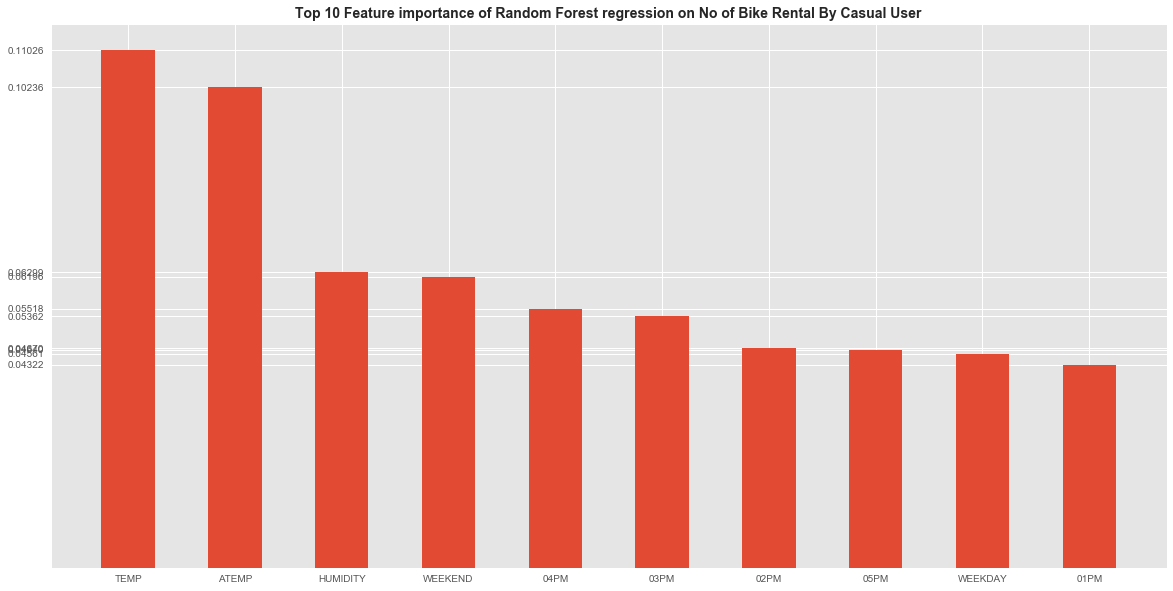

In [52]:
feature = rf_casual.feature_importances_.tolist()
columns = X.columns.tolist()
featureimportancesList = list(zip(columns,feature))
sortedfeatureimportancesList = sorted(featureimportancesList,key=lambda x: x[1], reverse=True)
top=sortedfeatureimportancesList[:10]

fig = plt.figure(figsize=(20, 10))

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.5

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.title('Top 10 Feature importance of Random Forest regression on No of Bike Rental By Casual User', fontsize = 14, fontweight = 'bold');

plt.show()

##### Gradient Boosting Model - Casual User

Test R2 on demand for bike rental by casual user using Gradient Boosting prediction is 0.84
MSE for training response data: 54.31
MSE for test response data: 354.94


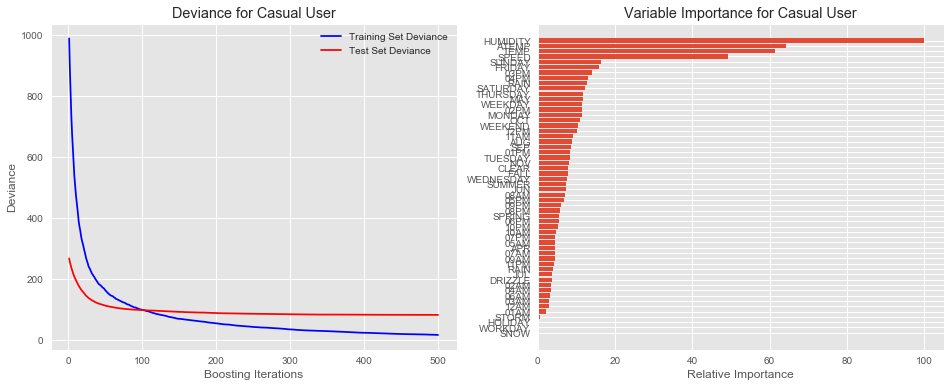

MSE: 496.739450548023 
SE: 71.63266407533023


In [53]:
X = dfRental
y = dfHourlyRental['CASUAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gb_casual = GradientBoostingRegressor(**params).fit(X_train, y_train)

mse = mean_squared_error(y_test, gb_casual.predict(X_test))
r2 = r2_score(y_test, gb_casual.predict(X_test))

gbCasScore = round(gb_casual.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by casual user using Gradient Boosting prediction is {}'.format(gbCasScore))

gbMseTrnCas = round(np.mean((gb_casual.predict(X_train) - y_train) **2),2)
gbMseTstCas = round(np.mean((gb_casual.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(gbMseTrnCas))
print('MSE for test response data: {:.2f}'.format(gbMseTstCas))

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gb_casual.staged_predict(X_test)):
    test_score[i] = gb_casual.loss_(y_test, y_pred)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance for Casual User')
plt.plot(np.arange(params['n_estimators']) + 1, gb_casual.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

feature_importance = gb_casual.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for Casual User')

plt.show()

#Find MSE on No Of Bike Rental prediction by casual user using 5 K-folds
kf = KFold(5, shuffle = True)
scores = cross_val_score(gb_casual, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

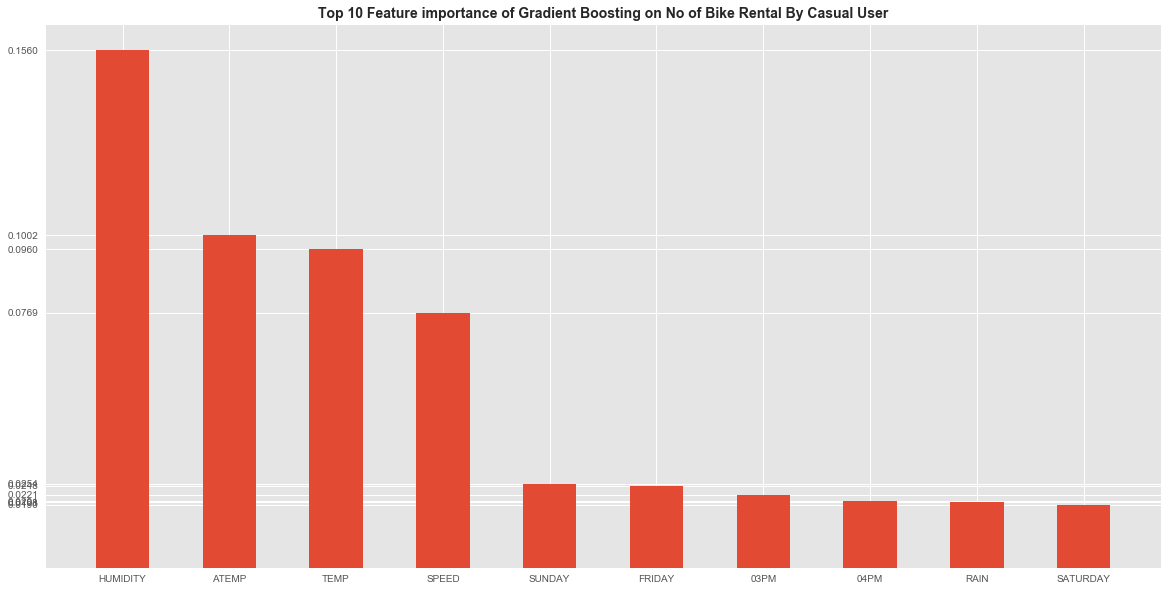

In [54]:
feature = gb_casual.feature_importances_.tolist()
columns = X.columns.tolist()
featureimportancesList = list(zip(columns,feature))
sortedfeatureimportancesList = sorted(featureimportancesList,key=lambda x: x[1], reverse=True)
top=sortedfeatureimportancesList[:10]

fig = plt.figure(figsize=(20, 10))

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.5

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.title('Top 10 Feature importance of Gradient Boosting on No of Bike Rental By Casual User', fontsize = 14, fontweight = 'bold');

plt.show()

##### Linear Regression Model - All User

           estimatedCoefficients
TEMP                6.860025e-02
ATEMP               7.926594e-01
HUMIDITY           -1.301275e-01
SPEED              -3.160467e+00
RAIN                1.978009e+00
SNOW                8.279366e+16
SPRING              8.285307e+14
SUMMER              8.285307e+14
FALL                8.285307e+14
12AM               -2.733553e+14
01AM               -2.733553e+14
02AM               -2.733553e+14
03AM               -2.733553e+14
04AM               -2.733553e+14
05AM               -2.733553e+14
06AM               -2.733553e+14
07AM               -2.733553e+14
08AM               -2.733553e+14
09AM               -2.733553e+14
10AM               -2.733553e+14
11AM               -2.733553e+14
12PM               -2.733553e+14
01PM               -2.733553e+14
02PM               -2.733553e+14
03PM               -2.733553e+14
04PM               -2.733553e+14
05PM               -2.733553e+14
06PM               -2.733553e+14
07PM               -2.733553e+14
08PM      

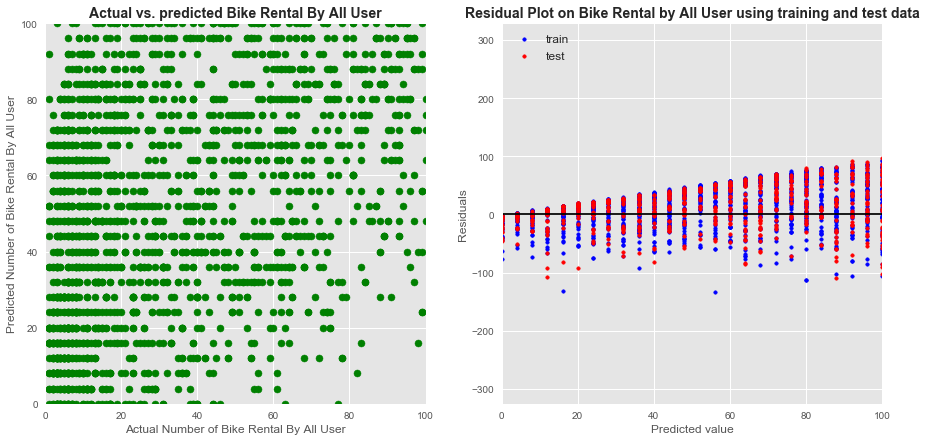

MSE: 5940.54 
SE: 364.86


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = dfRental
y = dfHourlyRental['TOTAL']

#Need to normalize due to wide variance between features
lmAll = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

XAllTrnLn = X_train.copy()
XAllTstLn = X_test.copy()
yAllTrnLn = y_train.copy()
yAllTstLn = y_test.copy()

#Fit on training data
model = lmAll.fit(X_train, y_train)

#Look at coefficients of the model
print(pd.DataFrame(lmAll.coef_, index = X.columns, columns = ['estimatedCoefficients']))

lmAllScore = round(lmAll.score(X_test, y_test),2)

print('Test R2 on Bike Rental by all user using Linear Regression prediction {}'.format(lmAllScore))

lmMseTrnAll = round(np.mean((lmAll.predict(X_train) - y_train) **2),2)
lmMseTstAll = round(np.mean((lmAll.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(lmMseTrnAll))
print('MSE for test response data: {:.2f}'.format(lmMseTstAll))

fig = plt.figure(figsize=(15,7))

#Plot actual vs. predicted on number of Bike Rental
plt.subplot(1,2,1)
plt.scatter(y, lmAll.predict(X), c='g');
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Actual Number of Bike Rental By All User', fontsize = 12);
plt.ylabel('Predicted Number of Bike Rental By All User', fontsize = 12);
plt.title('Actual vs. predicted Bike Rental By All User', fontsize = 14, fontweight = 'bold');

#Plot residuals of number of Bike Rental
plt.subplot(1,2,2)
plt.scatter(lmAll.predict(X_train), lmAll.predict(X_train) - y_train, c='b', marker = '.', label = 'train')
plt.scatter(lmAll.predict(X_test), lmAll.predict(X_test) - y_test, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=0, xmax = 100)
plt.title('Residual Plot on Bike Rental by All User using training and test data', fontsize = 14, fontweight = 'bold');
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,100]);
plt.legend(fontsize = 12, loc = 2)

plt.show()

#Using K-folds and cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle = True)
lmAllCv = LinearRegression(normalize = True)

#Find MSE on number of Bike Rental prediction
scores = cross_val_score(lmAllCv, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

##### Random Forest Model - All User

Test R2 on demand for bike renal for all user using Random Forest prediction 0.81
MSE for training response data: 659.69
MSE for test response data: 3338.04


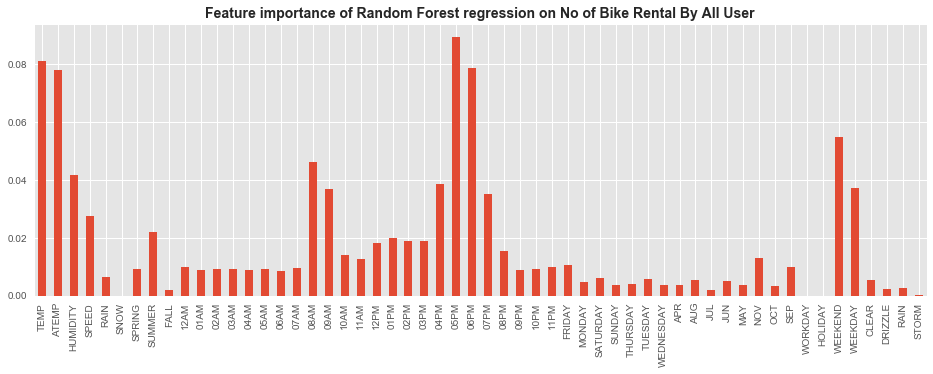

MSE: 3747.7342776672085 
SE: 140.17029230451158


In [56]:
X = dfRental
y = dfHourlyRental['TOTAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

rfAll = RandomForestRegressor(random_state = 0)

rfAll.fit(X_train, y_train)

rfAllScore = round(rfAll.score(X_test, y_test),2)

print('Test R2 on demand for bike renal for all user using Random Forest prediction {}'.format(rfAllScore))

rfMseTrnAll = round(np.mean((rfAll.predict(X_train) - y_train) **2),2)
rfMseTstAll = round(np.mean((rfAll.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(rfMseTrnAll))
print('MSE for test response data: {:.2f}'.format(rfMseTstAll))

all_features = pd.Series(rfAll.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(16,5));
all_features.plot(kind = 'bar');
plt.title('Feature importance of Random Forest regression on No of Bike Rental By All User', fontsize = 14, fontweight = 'bold');

plt.show()

#Find MSE on number of Bike Rental prediction using 5 K-folds for Casual User
kf = KFold(5, shuffle = True)
rfAllCv = cross_val_score(rf_casual, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(rfAllCv)), rfAllCv.std()))

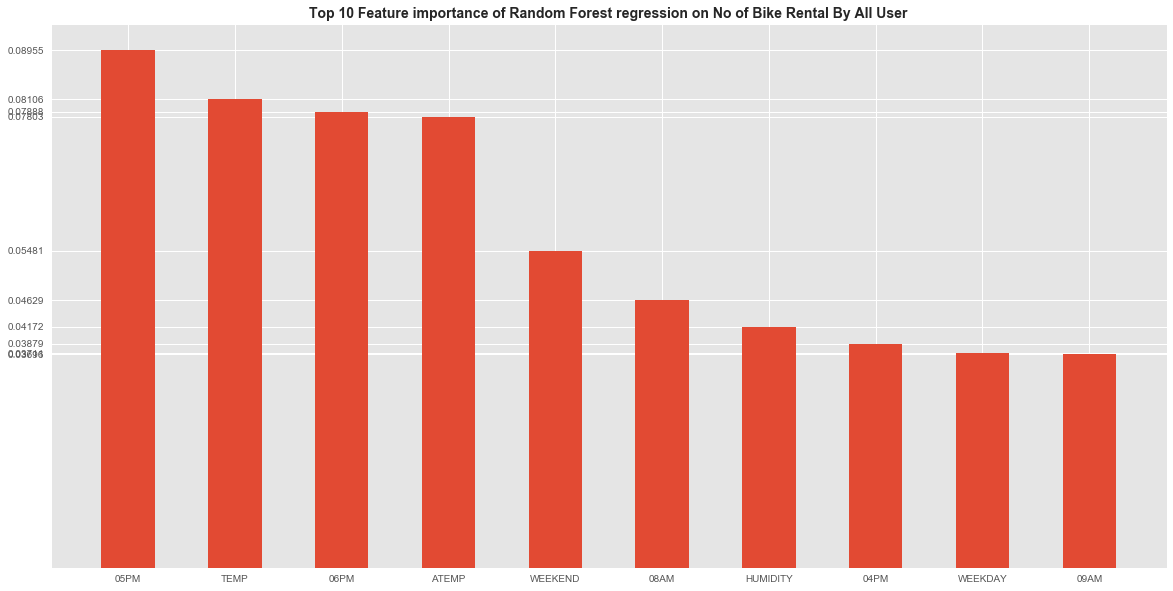

In [57]:
feature = rfAll.feature_importances_.tolist()
columns = X.columns.tolist()
featureimportancesList = list(zip(columns,feature))
sortedfeatureimportancesList = sorted(featureimportancesList,key=lambda x: x[1], reverse=True)
top=sortedfeatureimportancesList[:10]

fig = plt.figure(figsize=(20, 10))

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.5

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.title('Top 10 Feature importance of Random Forest regression on No of Bike Rental By All User', fontsize = 14, fontweight = 'bold');

plt.show()

##### Gradient Boosting Model - All User

Test R2 on demand for bike rental by all user using Gradient Boosting prediction is 0.87
MSE for training response data: 396.27
MSE for test response data: 2365.90


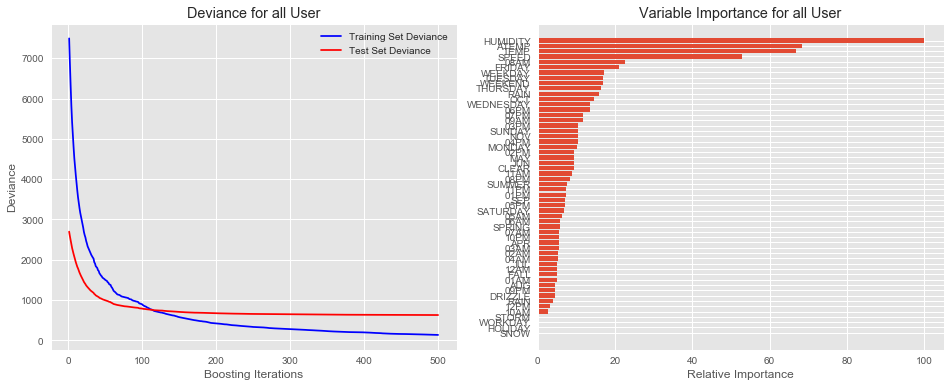

MSE: 3028.715392158247 
SE: 308.54616644246624


In [58]:
X = dfRental
y = dfHourlyRental['TOTAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gbAll = GradientBoostingRegressor(**params).fit(X_train, y_train)

mse = mean_squared_error(y_test, gbAll.predict(X_test))
r2 = r2_score(y_test, gbAll.predict(X_test))

gbAllScore = round(gbAll.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by all user using Gradient Boosting prediction is {}'.format(gbAllScore))

gbMseTrnAll = round(np.mean((gbAll.predict(X_train) - y_train) **2),2)
gbMseTstAll = round(np.mean((gbAll.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(gbMseTrnAll))
print('MSE for test response data: {:.2f}'.format(gbMseTstAll))

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbAll.staged_predict(X_test)):
    test_score[i] = gbAll.loss_(y_test, y_pred)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance for all User')
plt.plot(np.arange(params['n_estimators']) + 1, gbAll.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

feature_importance = gbAll.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for all User')
plt.show()

#Find MSE on No Of Bike Rental prediction by all user using 5 K-folds
kf = KFold(5, shuffle = True)
gbAllCv = cross_val_score(gbAll, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(gbAllCv)), gbAllCv.std()))

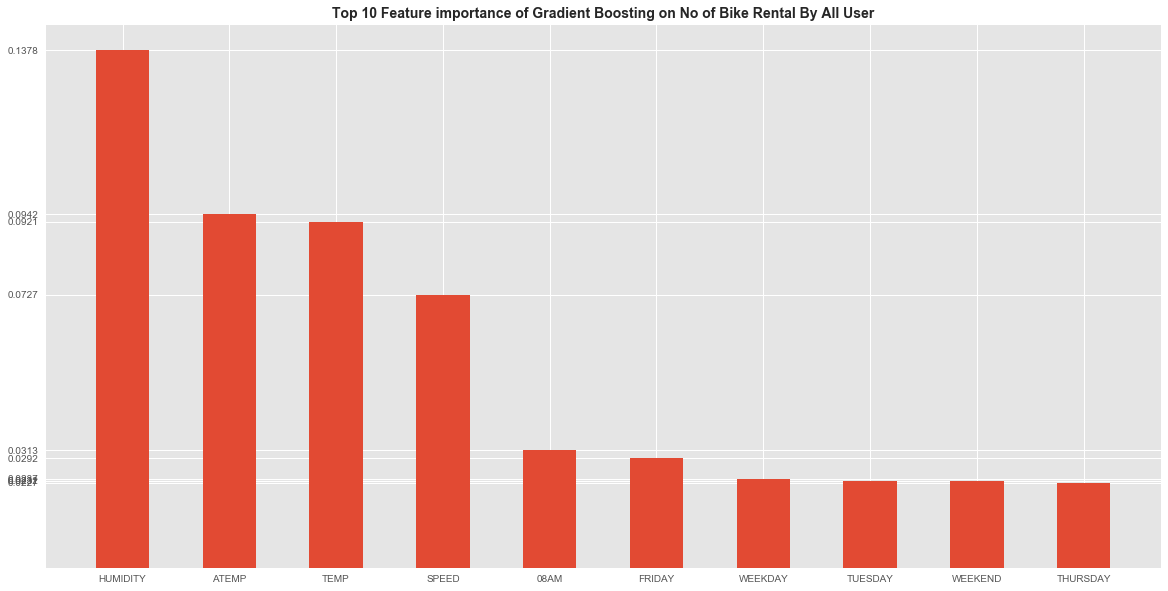

In [59]:
feature = gbAll.feature_importances_.tolist()
columns = X.columns.tolist()
featureimportancesList = list(zip(columns,feature))
sortedfeatureimportancesList = sorted(featureimportancesList,key=lambda x: x[1], reverse=True)
top=sortedfeatureimportancesList[:10]

fig = plt.figure(figsize=(20, 10))

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.5

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.title('Top 10 Feature importance of Gradient Boosting on No of Bike Rental By All User', fontsize = 14, fontweight = 'bold');

plt.show()

We are going to add a new feature "Type Of Rider" to the dataset and try to predict the best model

In [60]:
dfHourlyRentalReg = dfHourlyRental.copy()
dropFeatures = ["DURATION","CASUAL","TOTAL","START_DATE"]
dfHourlyRentalReg  = dfHourlyRentalReg.drop(dropFeatures,axis=1)
dfHourlyRentalReg = dfHourlyRentalReg.rename(columns = {'REGISTERED':'COUNT'})
dfHourlyRentalReg.insert(13, 'TYPE', 1)

dfHourlyRentalCas = dfHourlyRental.copy()
dropFeatures = ["DURATION","REGISTERED","TOTAL","START_DATE"]
dfHourlyRentalCas  = dfHourlyRentalCas.drop(dropFeatures,axis=1)
dfHourlyRentalCas = dfHourlyRentalCas.rename(columns = {'CASUAL':'COUNT'})
dfHourlyRentalCas.insert(13, 'TYPE', 0)

dfHourlyRentalComb = dfHourlyRentalCas.append(dfHourlyRentalReg)
dfHourlyRentalComb.head(5)

,SEASON,HOUR,WEEKDAY,MONTH,HOLIDAY,WORKDAY,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,WEATHER,TYPE,COUNT
0,3,13,Monday,Oct,0,0,57,57,68,3,0.0,0.0,1,0,30
1,3,14,Tuesday,Oct,0,0,59,59,68,3,0.0,0.0,1,0,36
2,3,15,Tuesday,Oct,0,0,62,62,64,3,0.0,0.0,1,0,26
3,3,16,Tuesday,Oct,0,0,62,62,64,4,0.0,0.0,1,0,17
4,3,17,Tuesday,Oct,0,0,63,63,64,4,0.0,0.0,1,0,20


In [61]:
dfRentalComb = pd.get_dummies(dfHourlyRentalComb, columns=['SEASON','HOUR','WEEKDAY','MONTH','HOLIDAY','WORKDAY','WEATHER', 'TYPE'])

dfRentalComb.head(5)

,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,COUNT,SEASON_1,SEASON_2,SEASON_3,...,HOLIDAY_0,HOLIDAY_1,WORKDAY_0,WORKDAY_1,WEATHER_1,WEATHER_2,WEATHER_3,WEATHER_4,TYPE_0,TYPE_1
0,57,57,68,3,0.0,0.0,30,0,0,1,...,1,0,1,0,1,0,0,0,1,0
1,59,59,68,3,0.0,0.0,36,0,0,1,...,1,0,1,0,1,0,0,0,1,0
2,62,62,64,3,0.0,0.0,26,0,0,1,...,1,0,1,0,1,0,0,0,1,0
3,62,62,64,4,0.0,0.0,17,0,0,1,...,1,0,1,0,1,0,0,0,1,0
4,63,63,64,4,0.0,0.0,20,0,0,1,...,1,0,1,0,1,0,0,0,1,0


In [62]:
dfRentalComb.rename(columns={'WEEKDAY_Friday':'FRIDAY', 
                         'WEEKDAY_Monday':'MONDAY',
                         'WEEKDAY_Saturday': 'SATURDAY',
                         'WEEKDAY_Sunday': 'SUNDAY',
                         'WEEKDAY_Thursday': 'THURSDAY',
                         'WEEKDAY_Tuesday': 'TUESDAY',
                         'WEEKDAY_Wednesday': 'WEDNESDAY',
                         'MONTH_Apr': 'APR',
                         'MONTH_Aug': "AUG",
                         'MONTH_Jul': 'JUL',
                         'MONTH_Jun': 'JUN',
                         'MONTH_May': 'MAY',
                         'MONTH_Nov': 'NOV',
                         'MONTH_Oct': 'OCT',
                         'MONTH_Sep': 'SEP',
                         'SEASON_1': 'SPRING',
                         'SEASON_2': 'SUMMER',
                         'SEASON_3': 'FALL',
                         'HOUR_0': '12AM',      
                         'HOUR_1': '01AM',      
                         'HOUR_2': '02AM',     
                         'HOUR_3': '03AM',      
                         'HOUR_4': '04AM',      
                         'HOUR_5': '05AM',      
                         'HOUR_6': '06AM',      
                         'HOUR_7': '07AM',      
                         'HOUR_8': '08AM',      
                         'HOUR_9': '09AM',      
                         'HOUR_10': '10AM',     
                         'HOUR_11': '11AM',     
                         'HOUR_12': '12PM',     
                         'HOUR_13': '01PM',     
                         'HOUR_14': '02PM',     
                         'HOUR_15': '03PM',     
                         'HOUR_16': '04PM',     
                         'HOUR_17': '05PM',     
                         'HOUR_18': '06PM',     
                         'HOUR_19': '07PM',     
                         'HOUR_20': '08PM',     
                         'HOUR_21': '09PM',     
                         'HOUR_22': '10PM',     
                         'HOUR_23': '11PM',
                         'WEATHER_1': 'CLEAR',
                         'WEATHER_2': 'DRIZZLE',
                         'WEATHER_3': 'RAIN',
                         'WEATHER_4': 'STORM',
                         'HOLIDAY_0': 'WORKDAY',
                         'HOLIDAY_1': 'HOLIDAY',
                         'WORKDAY_0': 'WEEKEND',
                         'WORKDAY_1': 'WEEKDAY',
                         'TYPE_1': 'REGISTERED',
                         'TYPE_0': 'CASUAL'
                      }, inplace=True)

##### Linear Regression Model with additional feature "Type Of Rider"

            estimatedCoefficients
TEMP                -1.006875e-01
ATEMP                4.721405e-01
HUMIDITY            -3.629937e-02
SPEED               -1.458118e+00
RAIN                 7.204262e-01
SNOW                -9.955370e+15
SPRING              -5.064602e+13
SUMMER              -5.064602e+13
FALL                -5.064602e+13
12AM                -1.579512e+12
01AM                -1.579512e+12
02AM                -1.579512e+12
03AM                -1.579512e+12
04AM                -1.579512e+12
05AM                -1.579512e+12
06AM                -1.579512e+12
07AM                -1.579512e+12
08AM                -1.579512e+12
09AM                -1.579512e+12
10AM                -1.579512e+12
11AM                -1.579512e+12
12PM                -1.579512e+12
01PM                -1.579512e+12
02PM                -1.579512e+12
03PM                -1.579512e+12
04PM                -1.579512e+12
05PM                -1.579512e+12
06PM                -1.579512e+12
07PM          

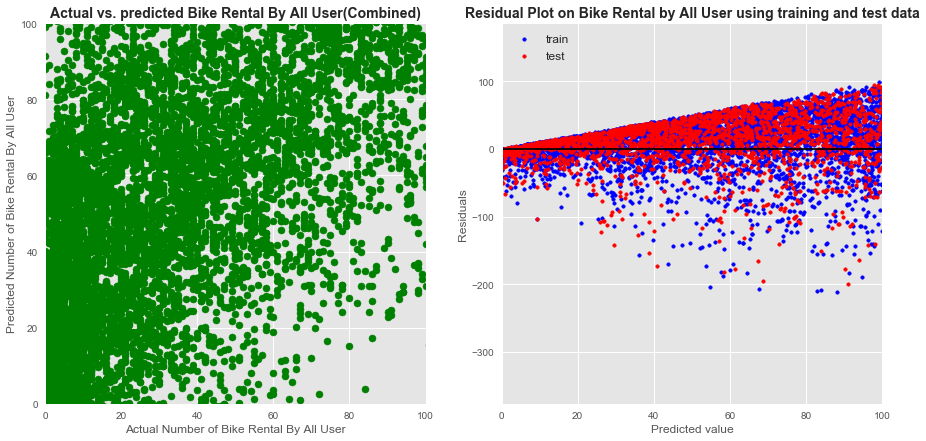

In [96]:
X = dfRentalComb.copy()
del X['COUNT']
y = dfRentalComb['COUNT']

#Need to normalize due to wide variance between features
lmComb = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#Fit on training data
model = lmComb.fit(X_train, y_train)

#Look at coefficients of the model
print(pd.DataFrame(lmComb.coef_, index = X.columns, columns = ['estimatedCoefficients']))

lmCombScore = round(lmComb.score(X_test, y_test),2)

print('Test R2 on Bike Rental by all user using Linear Regression prediction {}'.format(lmCombScore))

lmMseTrnComb = round(np.mean((lmComb.predict(X_train) - y_train) **2),2)
lmMseTstComb = round(np.mean((lmComb.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(lmMseTrnComb))
print('MSE for test response data: {:.2f}'.format(lmMseTrnComb))

fig = plt.figure(figsize=(15,7))

#Plot actual vs. predicted on number of Bike Rental
plt.subplot(1,2,1)
plt.scatter(y, lmComb.predict(X), c='g');
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Actual Number of Bike Rental By All User', fontsize = 12);
plt.ylabel('Predicted Number of Bike Rental By All User', fontsize = 12);
plt.title('Actual vs. predicted Bike Rental By All User(Combined)', fontsize = 14, fontweight = 'bold');

#Plot residuals of number of Bike Rental
plt.subplot(1,2,2)
plt.scatter(lmComb.predict(X_train), lmComb.predict(X_train) - y_train, c='b', marker = '.', label = 'train')
plt.scatter(lmComb.predict(X_test), lmComb.predict(X_test) - y_test, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=0, xmax = 100)
plt.title('Residual Plot on Bike Rental by All User using training and test data', fontsize = 14, fontweight = 'bold');
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,100]);
plt.legend(fontsize = 12, loc = 2)

plt.show()

##### Random Forest Model with additional feature "Type Of Rider"

In [97]:
X = dfRentalComb.copy()
del X['COUNT']
y = dfRentalComb['COUNT']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

rfComb = RandomForestRegressor(random_state = 0)

rfComb.fit(X_train, y_train)

rfCombScore = round(rfComb.score(X_test, y_test),2)

print('Test R2 on demand for bike renal for all user using Random Forest prediction {}'.format(rfCombScore))

rfMseTrnComb = round(np.mean((rfComb.predict(X_train) - y_train) **2),2)
rfMseTstComb = round(np.mean((rfComb.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(rfMseTrnComb))
print('MSE for test response data: {:.2f}'.format(rfMseTstComb))

Test R2 on demand for bike renal for all user using Random Forest prediction 0.81
MSE for training response data: 248.66
MSE for test response data: 1401.63


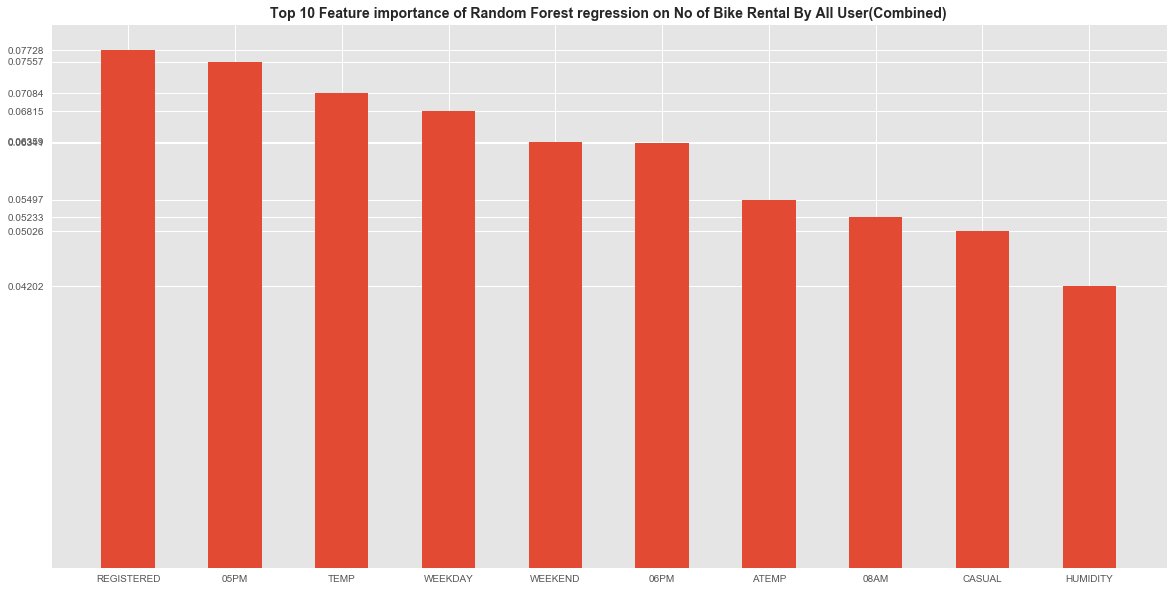

In [98]:
feature = rfComb.feature_importances_.tolist()
columns = X.columns.tolist()
featureimportancesList = list(zip(columns,feature))
sortedfeatureimportancesList = sorted(featureimportancesList,key=lambda x: x[1], reverse=True)
top=sortedfeatureimportancesList[:10]

fig = plt.figure(figsize=(20, 10))

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.5

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.title('Top 10 Feature importance of Random Forest regression on No of Bike Rental By All User(Combined)', fontsize = 14, fontweight = 'bold');

plt.show()

##### Gradient Boosting Model with additional feature "Type Of Rider"

In [99]:
X = dfRentalComb.copy()
del X['COUNT']
y = dfRentalComb['COUNT']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gbComb = GradientBoostingRegressor(**params).fit(X_train, y_train)

mse = mean_squared_error(y_test, gbComb.predict(X_test))
r2 = r2_score(y_test, gbComb.predict(X_test))

gbCombScore = round(gbComb.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by all user using Gradient Boosting prediction is {}'.format(gbCombScore))

gbMseTrnComb = round(np.mean((gbComb.predict(X_train) - y_train) **2),2)
gbMseTstComb = round(np.mean((gbComb.predict(X_test) - y_test) **2),2)

print('MSE for training response data: {:.2f}'.format(gbMseTrnComb))
print('MSE for test response data: {:.2f}'.format(gbMseTstComb))

Test R2 on demand for bike rental by all user using Gradient Boosting prediction is 0.86
MSE for training response data: 313.67
MSE for test response data: 1041.00


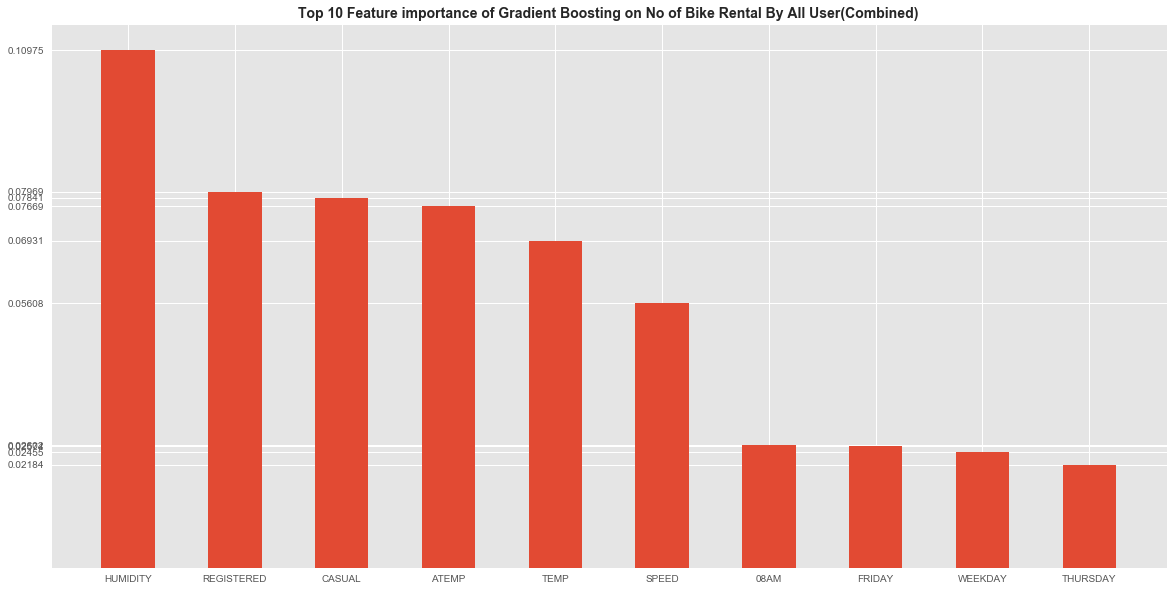

In [101]:
feature = gbComb.feature_importances_.tolist()
columns = X.columns.tolist()
featureimportancesList = list(zip(columns,feature))
sortedfeatureimportancesList = sorted(featureimportancesList,key=lambda x: x[1], reverse=True)
top=sortedfeatureimportancesList[:10]

fig = plt.figure(figsize=(20, 10))

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.5

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.title('Top 10 Feature importance of Gradient Boosting on No of Bike Rental By All User(Combined)', fontsize = 14, fontweight = 'bold');

plt.show()

##### Compare Test R2 against all Model

In [66]:
lstR2 = list((('Linear Regression', format(lmRegScore),format(lmCasScore),format(lmAllScore), format(lmCombScore)), 
            ('Random Forest', format(rfRegScore),format(rfCasScore),format(rfAllScore),format(rfCombScore)),
            ('Gradient Boosting', format(gbRegScore),format(gbCasScore),format(gbAllScore),format(gbCombScore))))

dfR2 = pd.DataFrame(lstR2)

dfR2.columns = ['Model','Registered User (M1)','Casual User (M2)','All User (M3)','All User (Combined)']

dfR2

,Model,Registered User (M1),Casual User (M2),All User (M3),All User (Combined)
0,Linear Regression,0.6,0.58,0.63,0.5
1,Random Forest,0.81,0.76,0.81,0.81
2,Gradient Boosting,0.85,0.84,0.87,0.86


##### Compare MSE for test response data against all Model

In [67]:
lstMse = list((('Linear Regression', format(lmMseTstReg),format(lmMseTstCas),format(lmMseTstAll), format(lmMseTstComb)), 
            ('Random Forest', format(rfMseTstReg),format(rfMseTstCas),format(rfMseTstAll),format(rfMseTstComb)),
            ('Gradient Boosting', format(gbMseTstReg),format(gbMseTstCas),format(gbMseTstAll),format(gbMseTstComb))))

dfMse = pd.DataFrame(lstMse)

dfMse.columns = ['Model','Registered User (M1)','Casual User (M2)','All User (M3)','All User (Combined)']

dfMse

,Model,Registered User (M1),Casual User (M2),All User (M3),All User (Combined)
0,Linear Regression,3776.83,830.7,5714.19,3490.64
1,Random Forest,2138.91,536.22,3338.04,1401.63
2,Gradient Boosting,1669.31,354.94,2365.9,1037.92
